# Italia - Cina (Hubei)

Confronto tra i trend italiano e cinese (provincia di Hubei).

## Fonti
* Dati italiani: Protezione Civile Italia <https://github.com/pcm-dpc/COVID-19>
* Dati cinesi: Johns Hopkins CSSE <https://github.com/CSSEGISandData/COVID-19>

Codice rilasciato in licenza MIT: <https://opensource.org/licenses/MIT>

Autore: *Emanuele Zeppieri*

In [955]:
import numpy as np

from scipy.signal import savgol_filter

import pandas as pd

import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe

from matplotlib.markers import CARETDOWN, CARETUP, CARETDOWNBASE, CARETUPBASE
import matplotlib.dates as mdates

import datetime as dt
from datetime import date, datetime, timedelta

from formatting_utilities import format_dates_from_numbers

%load_ext autoreload
%autoreload 2

# Global constants
# PLEASE CUSTOMIZE
OUTPUT_PATH = '../output'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [956]:
from matplotlib import rcParams
def set_plt_params():
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Century Schoolbook']
    rcParams['font.size'] = 14
    rcParams['figure.dpi'] = 300

In [957]:
ITA_SOURCE = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
CHN_SOURCE = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

In [958]:
# Italy data load
ds_it = pd.read_csv(ITA_SOURCE, parse_dates=['data'])
ds_it['data'] = ds_it['data'].dt.date
ds_it.set_index('data', inplace=True)

In [959]:
# Correzione dati errati 2020-03-10 nazionali
MISSING_CASES = 600
err_date = pd.to_datetime('2020-03-10').date()
err_date_p1 = err_date + timedelta(days=1)

ds_it.loc[err_date, 'totale_casi'] = 10_149 + MISSING_CASES
ds_it.loc[err_date, 'totale_attualmente_positivi'] = 8_514 + MISSING_CASES

ds_it.loc[err_date, 'nuovi_attualmente_positivi'] = 529 + MISSING_CASES
ds_it.loc[err_date_p1, 'nuovi_attualmente_positivi'] = 2076 - MISSING_CASES

In [960]:
# China data load & reshaping
ds_jhcsse = pd.read_csv(CHN_SOURCE)
hubei_row = ds_jhcsse.loc[ds_jhcsse['Province/State'] == 'Hubei'].copy()
hubei_row.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1, inplace=True)
ds_hubei = hubei_row.transpose(copy=True).rename(columns={62: 'totale_casi_hubei'})
ds_hubei.index = pd.to_datetime(ds_hubei.index).date
ds_hubei.index.rename('data', inplace=True)

In [961]:
# Merge & align lockdown dates
SHIFT_DAYS = -45

interesting_columns = ['totale_casi', 'totale_positivi', 'nuovi_positivi', 'variazione_totale_positivi']

ds_sided = pd.merge(left=ds_hubei, right=ds_it.loc[:, interesting_columns], on='data', how='outer')
ds_sided.loc[:, interesting_columns] = ds_sided.loc[:, interesting_columns].shift(periods=SHIFT_DAYS)

# Drop last (NaN) row
ds_sided.drop(ds_sided.tail(1).index, inplace=True)

# Check
ds_sided.head(30)

totale_casi_hubei  totale_casi  totale_positivi  nuovi_positivi  \
data                                                                          
2020-01-22              444.0       5883.0           5061.0          1247.0   
2020-01-23              444.0       7375.0           6387.0          1492.0   
2020-01-24              549.0       9172.0           7985.0          1797.0   
2020-01-25              761.0      10749.0           8514.0           977.0   
2020-01-26             1058.0      12462.0          10590.0          2313.0   
2020-01-27             1423.0      15113.0          12839.0          2651.0   
2020-01-28             3554.0      17660.0          14955.0          2547.0   
2020-01-29             3554.0      21157.0          17750.0          3497.0   
2020-01-30             4903.0      24747.0          20603.0          3590.0   
2020-01-31             5806.0      27980.0          23073.0          3233.0   
2020-02-01             7153.0      31506.0          26062.0          3526.0   
2020-02-02            11177.0      35713.0          28710.0          4207.0   
2020-02-03            13522.0      41035.0          33190.0          5322.0   
2020-02-04            16678.0      47021.0          37860.0          5986.0   
2020-02-05            19665.0      53578.0          42681.0          6557.0   
2020-02-06            22112.0      59138.0          46638.0          5560.0   
2020-02-07            24953.0      63927.0          50418.0          4789.0   
2020-02-08            27100.0      69176.0          54030.0          5249.0   
2020-02-09            29631.0      74386.0          57521.0          5210.0   
2020-02-10            31728.0      80539.0          62013.0          6153.0   
2020-02-11            33366.0      86498.0          66414.0          5959.0   
2020-02-12            33366.0      92472.0          70065.0          5974.0   
2020-02-13            48206.0      97689.0          73880.0          5217.0   
2020-02-14            54406.0     101739.0          75528.0          4050.0   
2020-02-15            56249.0     105792.0          77635.0          4053.0   
2020-02-16            58182.0     110574.0          80572.0          4782.0   
2020-02-17            59989.0     115242.0          83049.0          4668.0   
2020-02-18            61682.0     119827.0          85388.0          4585.0   
2020-02-19            62031.0     124632.0          88274.0          4805.0   
2020-02-20            62442.0          NaN              NaN             NaN   

            variazione_totale_positivi  
data                                    
2020-01-22                      1145.0  
2020-01-23                      1326.0  
2020-01-24                      1598.0  
2020-01-25                       529.0  
2020-01-26                      2076.0  
2020-01-27                      2249.0  
2020-01-28                      2116.0  
2020-01-29                      2795.0  
2020-01-30                      2853.0  
2020-01-31                      2470.0  
2020-02-01                      2989.0  
2020-02-02                      2648.0  
2020-02-03                      4480.0  
2020-02-04                      4670.0  
2020-02-05                      4821.0  
2020-02-06                      3957.0  
2020-02-07                      3780.0  
2020-02-08                      3612.0  
2020-02-09                      3491.0  
2020-02-10                      4492.0  
2020-02-11                      4401.0  
2020-02-12                      3651.0  
2020-02-13                      3815.0  
2020-02-14                      1648.0  
2020-02-15                      2107.0  
2020-02-16                      2937.0  
2020-02-17                      2477.0  
2020-02-18                      2339.0  
2020-02-19                      2886.0  
2020-02-20                         NaN

In [962]:
# Build short + long df's and cast index to integer (days)
START_DATE = '2020-01-24'
END_SHORT_PERIOD_DATE = '2020-02-12'

start_date = date.fromisoformat(START_DATE)
end_short_period_date = date.fromisoformat(END_SHORT_PERIOD_DATE)

ds_sided['totale_casi_hubei_firstfix'] = ds_sided['totale_casi_hubei']
# First fix suspect datapoint
ds_sided.loc[date.fromisoformat('2020-01-28'), ['totale_casi_hubei_firstfix']] = 2_488
ds_sided.loc[date.fromisoformat('2020-02-12'), ['totale_casi_hubei_firstfix']] = 38_312
# Fixing Hubei data
ds_sided['totale_casi_hubei_fixed'] = ds_sided['totale_casi_hubei_firstfix']
HUBEI_FIX_FACTOR = 46568/38312
ds_sided.loc[ds_sided.index <= date.fromisoformat('2020-02-12'), 'totale_casi_hubei_fixed'] = ds_sided['totale_casi_hubei_firstfix'] * HUBEI_FIX_FACTOR

df_sided_plot_long = ds_sided[(ds_sided.index >= start_date)].copy()
df_sided_plot_short = ds_sided[(ds_sided.index >= start_date) & (ds_sided.index <= end_short_period_date)].copy()

df_sided_plot_long.loc[:, ['totale_casi', 'totale_casi_hubei', 'totale_casi_hubei_fixed']].head(30)

totale_casi  totale_casi_hubei  totale_casi_hubei_fixed
data                                                               
2020-01-24       9172.0              549.0               667.306118
2020-01-25      10749.0              761.0               924.990812
2020-01-26      12462.0             1058.0              1285.992483
2020-01-27      15113.0             1423.0              1729.647734
2020-01-28      17660.0             3554.0              3024.148674
2020-01-29      21157.0             3554.0              4319.865108
2020-01-30      24747.0             4903.0              5959.566298
2020-01-31      27980.0             5806.0              7057.157235
2020-02-01      31506.0             7153.0              8694.427438
2020-02-02      35713.0            11177.0             13585.574650
2020-02-03      41035.0            13522.0             16435.907705
2020-02-04      47021.0            16678.0             20272.006264
2020-02-05      53578.0            19665.0             23902.686365
2020-02-06      59138.0            22112.0             26876.999791
2020-02-07      63927.0            24953.0             30330.217791
2020-02-08      69176.0            27100.0             32939.883065
2020-02-09      74386.0            29631.0             36016.297975
2020-02-10      80539.0            31728.0             38565.188557
2020-02-11      86498.0            33366.0             40556.167467
2020-02-12      92472.0            33366.0             46568.000000
2020-02-13      97689.0            48206.0             48206.000000
2020-02-14     101739.0            54406.0             54406.000000
2020-02-15     105792.0            56249.0             56249.000000
2020-02-16     110574.0            58182.0             58182.000000
2020-02-17     115242.0            59989.0             59989.000000
2020-02-18     119827.0            61682.0             61682.000000
2020-02-19     124632.0            62031.0             62031.000000
2020-02-20          NaN            62442.0             62442.000000
2020-02-21          NaN            62662.0             62662.000000
2020-02-22          NaN            64084.0             64084.000000

In [963]:
# Turn index from date into integer
if type(df_sided_plot_long.index[0]) is dt.date:
    df_sided_plot_long.index = (df_sided_plot_long.index - start_date).days + 1
if type(df_sided_plot_short.index[0]) is dt.date:
    df_sided_plot_short.index = (df_sided_plot_short.index - start_date).days + 1

In [964]:
# Scaling Italian data to Chinese data
ITALIAN_SCALING_FACTOR = 793/9172
df_sided_plot_short['totale_casi_scaled'] = df_sided_plot_short['totale_casi'] * ITALIAN_SCALING_FACTOR
df_sided_plot_long['totale_casi_scaled'] = df_sided_plot_long['totale_casi'] * ITALIAN_SCALING_FACTOR
# Check
df_sided_plot_long.loc[:, ['totale_casi_hubei', 'totale_casi_hubei_fixed', 'totale_casi', 'totale_casi_scaled', 'totale_positivi', 'nuovi_positivi']]
df_sided_plot_long

totale_casi_hubei  totale_casi  totale_positivi  nuovi_positivi  \
1               549.0       9172.0           7985.0          1797.0   
2               761.0      10749.0           8514.0           977.0   
3              1058.0      12462.0          10590.0          2313.0   
4              1423.0      15113.0          12839.0          2651.0   
5              3554.0      17660.0          14955.0          2547.0   
..                ...          ...              ...             ...   
67            67801.0          NaN              NaN             NaN   
68            67801.0          NaN              NaN             NaN   
69            67802.0          NaN              NaN             NaN   
70            67802.0          NaN              NaN             NaN   
71            67802.0          NaN              NaN             NaN   

    variazione_totale_positivi  totale_casi_hubei_firstfix  \
1                       1598.0                       549.0   
2                        529.0                       761.0   
3                       2076.0                      1058.0   
4                       2249.0                      1423.0   
5                       2116.0                      2488.0   
..                         ...                         ...   
67                         NaN                     67801.0   
68                         NaN                     67801.0   
69                         NaN                     67802.0   
70                         NaN                     67802.0   
71                         NaN                     67802.0   

    totale_casi_hubei_fixed  totale_casi_scaled  
1                667.306118          793.000000  
2                924.990812          929.345508  
3               1285.992483         1077.449411  
4               1729.647734         1306.651657  
5               3024.148674         1526.862189  
..                      ...                 ...  
67             67801.000000                 NaN  
68             67801.000000                 NaN  
69             67802.000000                 NaN  
70             67802.000000                 NaN  
71             67802.000000                 NaN  

[71 rows x 8 columns]

In [965]:
# Make the columns of equal length
df_sided_plot_same_length = df_sided_plot_long.dropna().copy()

# And just THEN (not before, otherwise dropna would drop the first row) add the deltas
df_sided_plot_long['totale_casi_DELTA'] = df_sided_plot_long['totale_casi'].diff()
df_sided_plot_long['totale_casi_hubei_fixed_DELTA'] = df_sided_plot_long['totale_casi_hubei_fixed'].diff()
df_sided_plot_same_length['totale_casi_DELTA'] = df_sided_plot_same_length['totale_casi'].diff()
df_sided_plot_same_length['totale_casi_hubei_fixed_DELTA'] = df_sided_plot_same_length['totale_casi_hubei_fixed'].diff()

# Check
df_sided_plot_same_length

totale_casi_hubei  totale_casi  totale_positivi  nuovi_positivi  \
1               549.0       9172.0           7985.0          1797.0   
2               761.0      10749.0           8514.0           977.0   
3              1058.0      12462.0          10590.0          2313.0   
4              1423.0      15113.0          12839.0          2651.0   
5              3554.0      17660.0          14955.0          2547.0   
6              3554.0      21157.0          17750.0          3497.0   
7              4903.0      24747.0          20603.0          3590.0   
8              5806.0      27980.0          23073.0          3233.0   
9              7153.0      31506.0          26062.0          3526.0   
10            11177.0      35713.0          28710.0          4207.0   
11            13522.0      41035.0          33190.0          5322.0   
12            16678.0      47021.0          37860.0          5986.0   
13            19665.0      53578.0          42681.0          6557.0   
14            22112.0      59138.0          46638.0          5560.0   
15            24953.0      63927.0          50418.0          4789.0   
16            27100.0      69176.0          54030.0          5249.0   
17            29631.0      74386.0          57521.0          5210.0   
18            31728.0      80539.0          62013.0          6153.0   
19            33366.0      86498.0          66414.0          5959.0   
20            33366.0      92472.0          70065.0          5974.0   
21            48206.0      97689.0          73880.0          5217.0   
22            54406.0     101739.0          75528.0          4050.0   
23            56249.0     105792.0          77635.0          4053.0   
24            58182.0     110574.0          80572.0          4782.0   
25            59989.0     115242.0          83049.0          4668.0   
26            61682.0     119827.0          85388.0          4585.0   
27            62031.0     124632.0          88274.0          4805.0   

    variazione_totale_positivi  totale_casi_hubei_firstfix  \
1                       1598.0                       549.0   
2                        529.0                       761.0   
3                       2076.0                      1058.0   
4                       2249.0                      1423.0   
5                       2116.0                      2488.0   
6                       2795.0                      3554.0   
7                       2853.0                      4903.0   
8                       2470.0                      5806.0   
9                       2989.0                      7153.0   
10                      2648.0                     11177.0   
11                      4480.0                     13522.0   
12                      4670.0                     16678.0   
13                      4821.0                     19665.0   
14                      3957.0                     22112.0   
15                      3780.0                     24953.0   
16                      3612.0                     27100.0   
17                      3491.0                     29631.0   
18                      4492.0                     31728.0   
19                      4401.0                     33366.0   
20                      3651.0                     38312.0   
21                      3815.0                     48206.0   
22                      1648.0                     54406.0   
23                      2107.0                     56249.0   
24                      2937.0                     58182.0   
25                      2477.0                     59989.0   
26                      2339.0                     61682.0   
27                      2886.0                     62031.0   

    totale_casi_hubei_fixed  totale_casi_scaled  totale_casi_DELTA  \
1                667.306118          793.000000                NaN   
2                924.990812          929.345508             1577.0   
3               1285.992483         1077.449411             1713.0  

In [966]:
# Only for Italy


In [967]:
SUBTITLE = 'Dati Italia: https://github.com/pcm-dpc/COVID-19 (dati del 10/03/2020 corretti) - Dati Cina: https://github.com/CSSEGISandData/COVID-19 \nCodice: https://github.com/emazep/COVID-19-Statistics'
SUBTITLE_NO_CHN = 'Fonte dati: https://github.com/pcm-dpc/COVID-19 (dati del 10/03/2020 corretti)\nCodice: https://github.com/emazep/COVID-19-Statistics'
common_plt_params = {'markersize':8, 'linewidth':4}

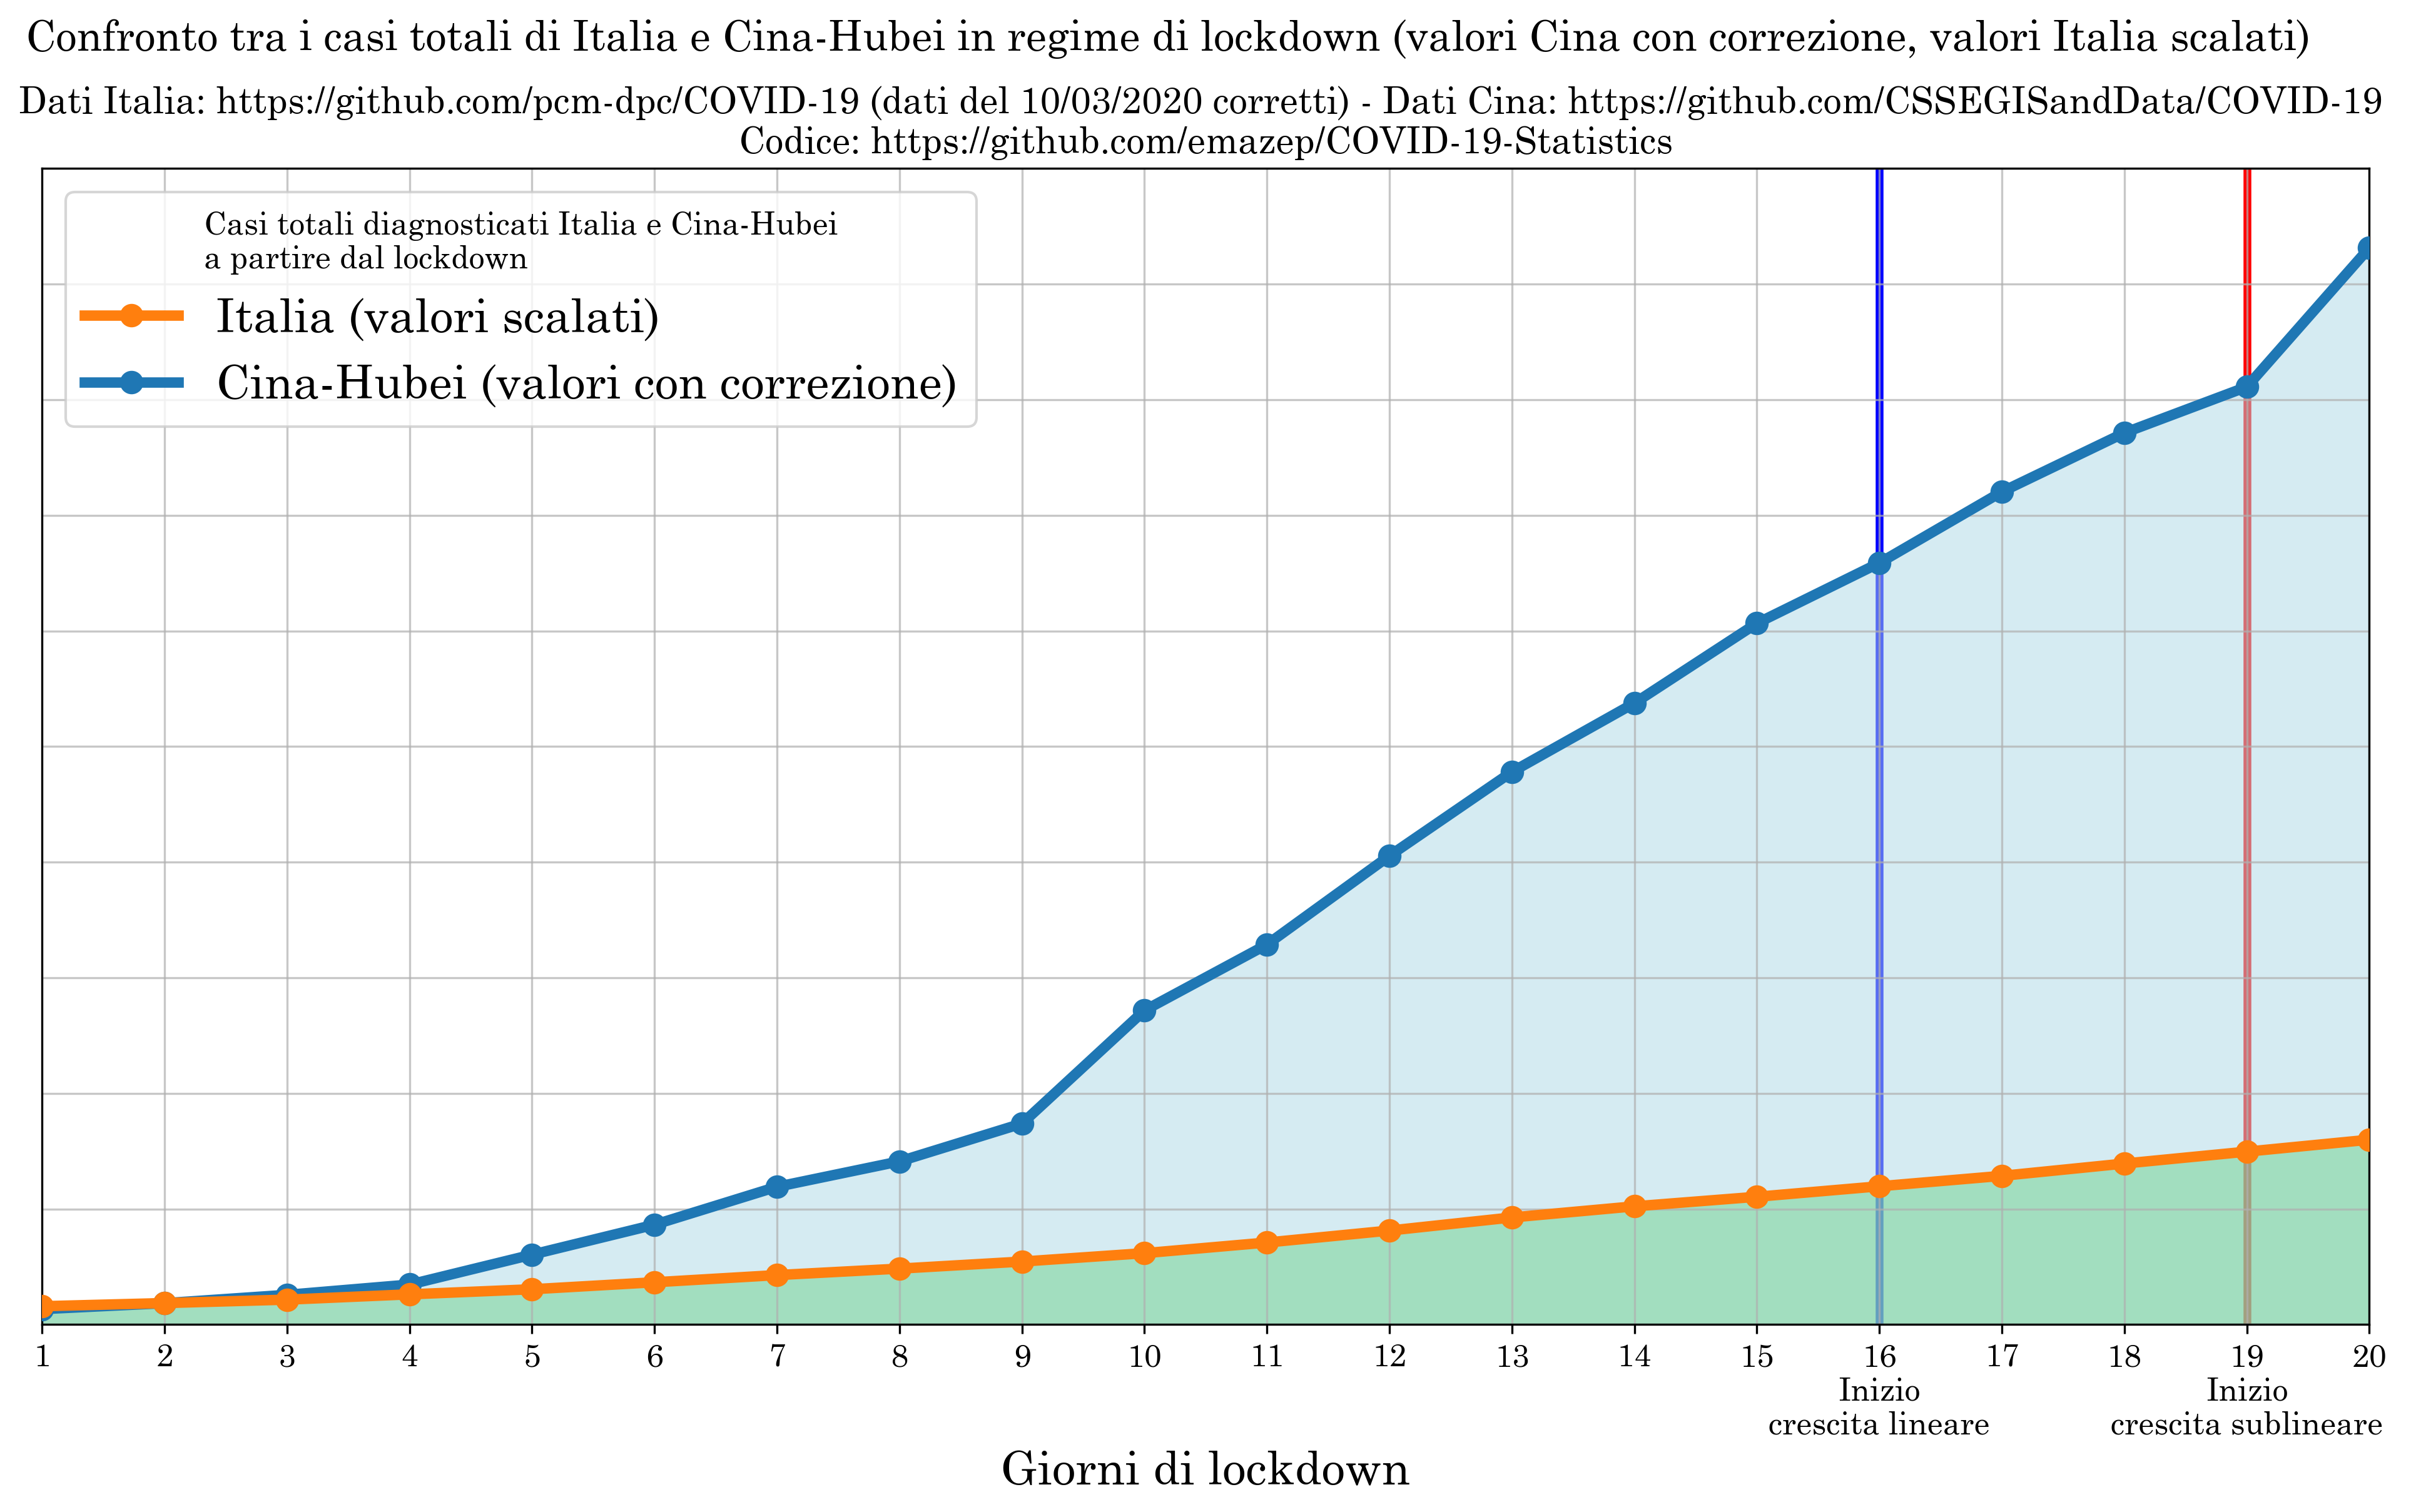

In [968]:
SLACK = 0.5
ALPHA = 0.7

ax = df_sided_plot_short.plot(
    y=['totale_casi_hubei_fixed', 'totale_casi_scaled'], label=['Cina-Hubei (valori con correzione)', 'Italia (valori scalati)'], **common_plt_params, marker='o', figsize=(16, 8), zorder=3
)
plt.fill_between(df_sided_plot_short.index, df_sided_plot_short['totale_casi_scaled'], color='limegreen', alpha=0.5)
plt.fill_between(df_sided_plot_short.index, df_sided_plot_short['totale_casi_hubei_fixed'], color='lightblue', alpha=0.5)

ax.tick_params(axis='x', which='both', labelsize=12)
plt.xticks(range(1,21), list(range(1,16))+['16\nInizio\ncrescita lineare']+list(range(17,19))+['19\nInizio\ncrescita sublineare']+list(range(20,21)))
#ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

'''
ax.yaxis.set_major_locator(ticker.MultipleLocator(10_000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax.tick_params(axis='y', which='both', labelsize=14)
ax.yaxis.set_label_position('right')
ax.yaxis.tick_right()
plt.ylabel('Casi totali Cina-Hubei corretti')
'''
ax.yaxis.set_major_locator(ticker.MultipleLocator(5_000))
ax.tick_params( axis='y', which='both', left=False)
ax.set_yticklabels([])

ax.grid(which='both', alpha=ALPHA)

plt.axvline(x=16, linewidth=3, zorder=0, color='blue')
plt.axvline(x=19, linewidth=3, zorder=0, color='red')
plt.ylim(bottom=0, top=50_000)
plt.xlabel('Giorni di lockdown', fontsize=18)

ax.set_title(SUBTITLE, fontsize=14)
plt.suptitle('Confronto tra i casi totali di Italia e Cina-Hubei in regime di lockdown (valori Cina con correzione, valori Italia scalati)', fontsize=16)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title="Casi totali diagnosticati Italia e Cina-Hubei\na partire dal lockdown", fontsize=18)

fig_ita_chn_corrected_scaled = plt.gcf()

plt.show()

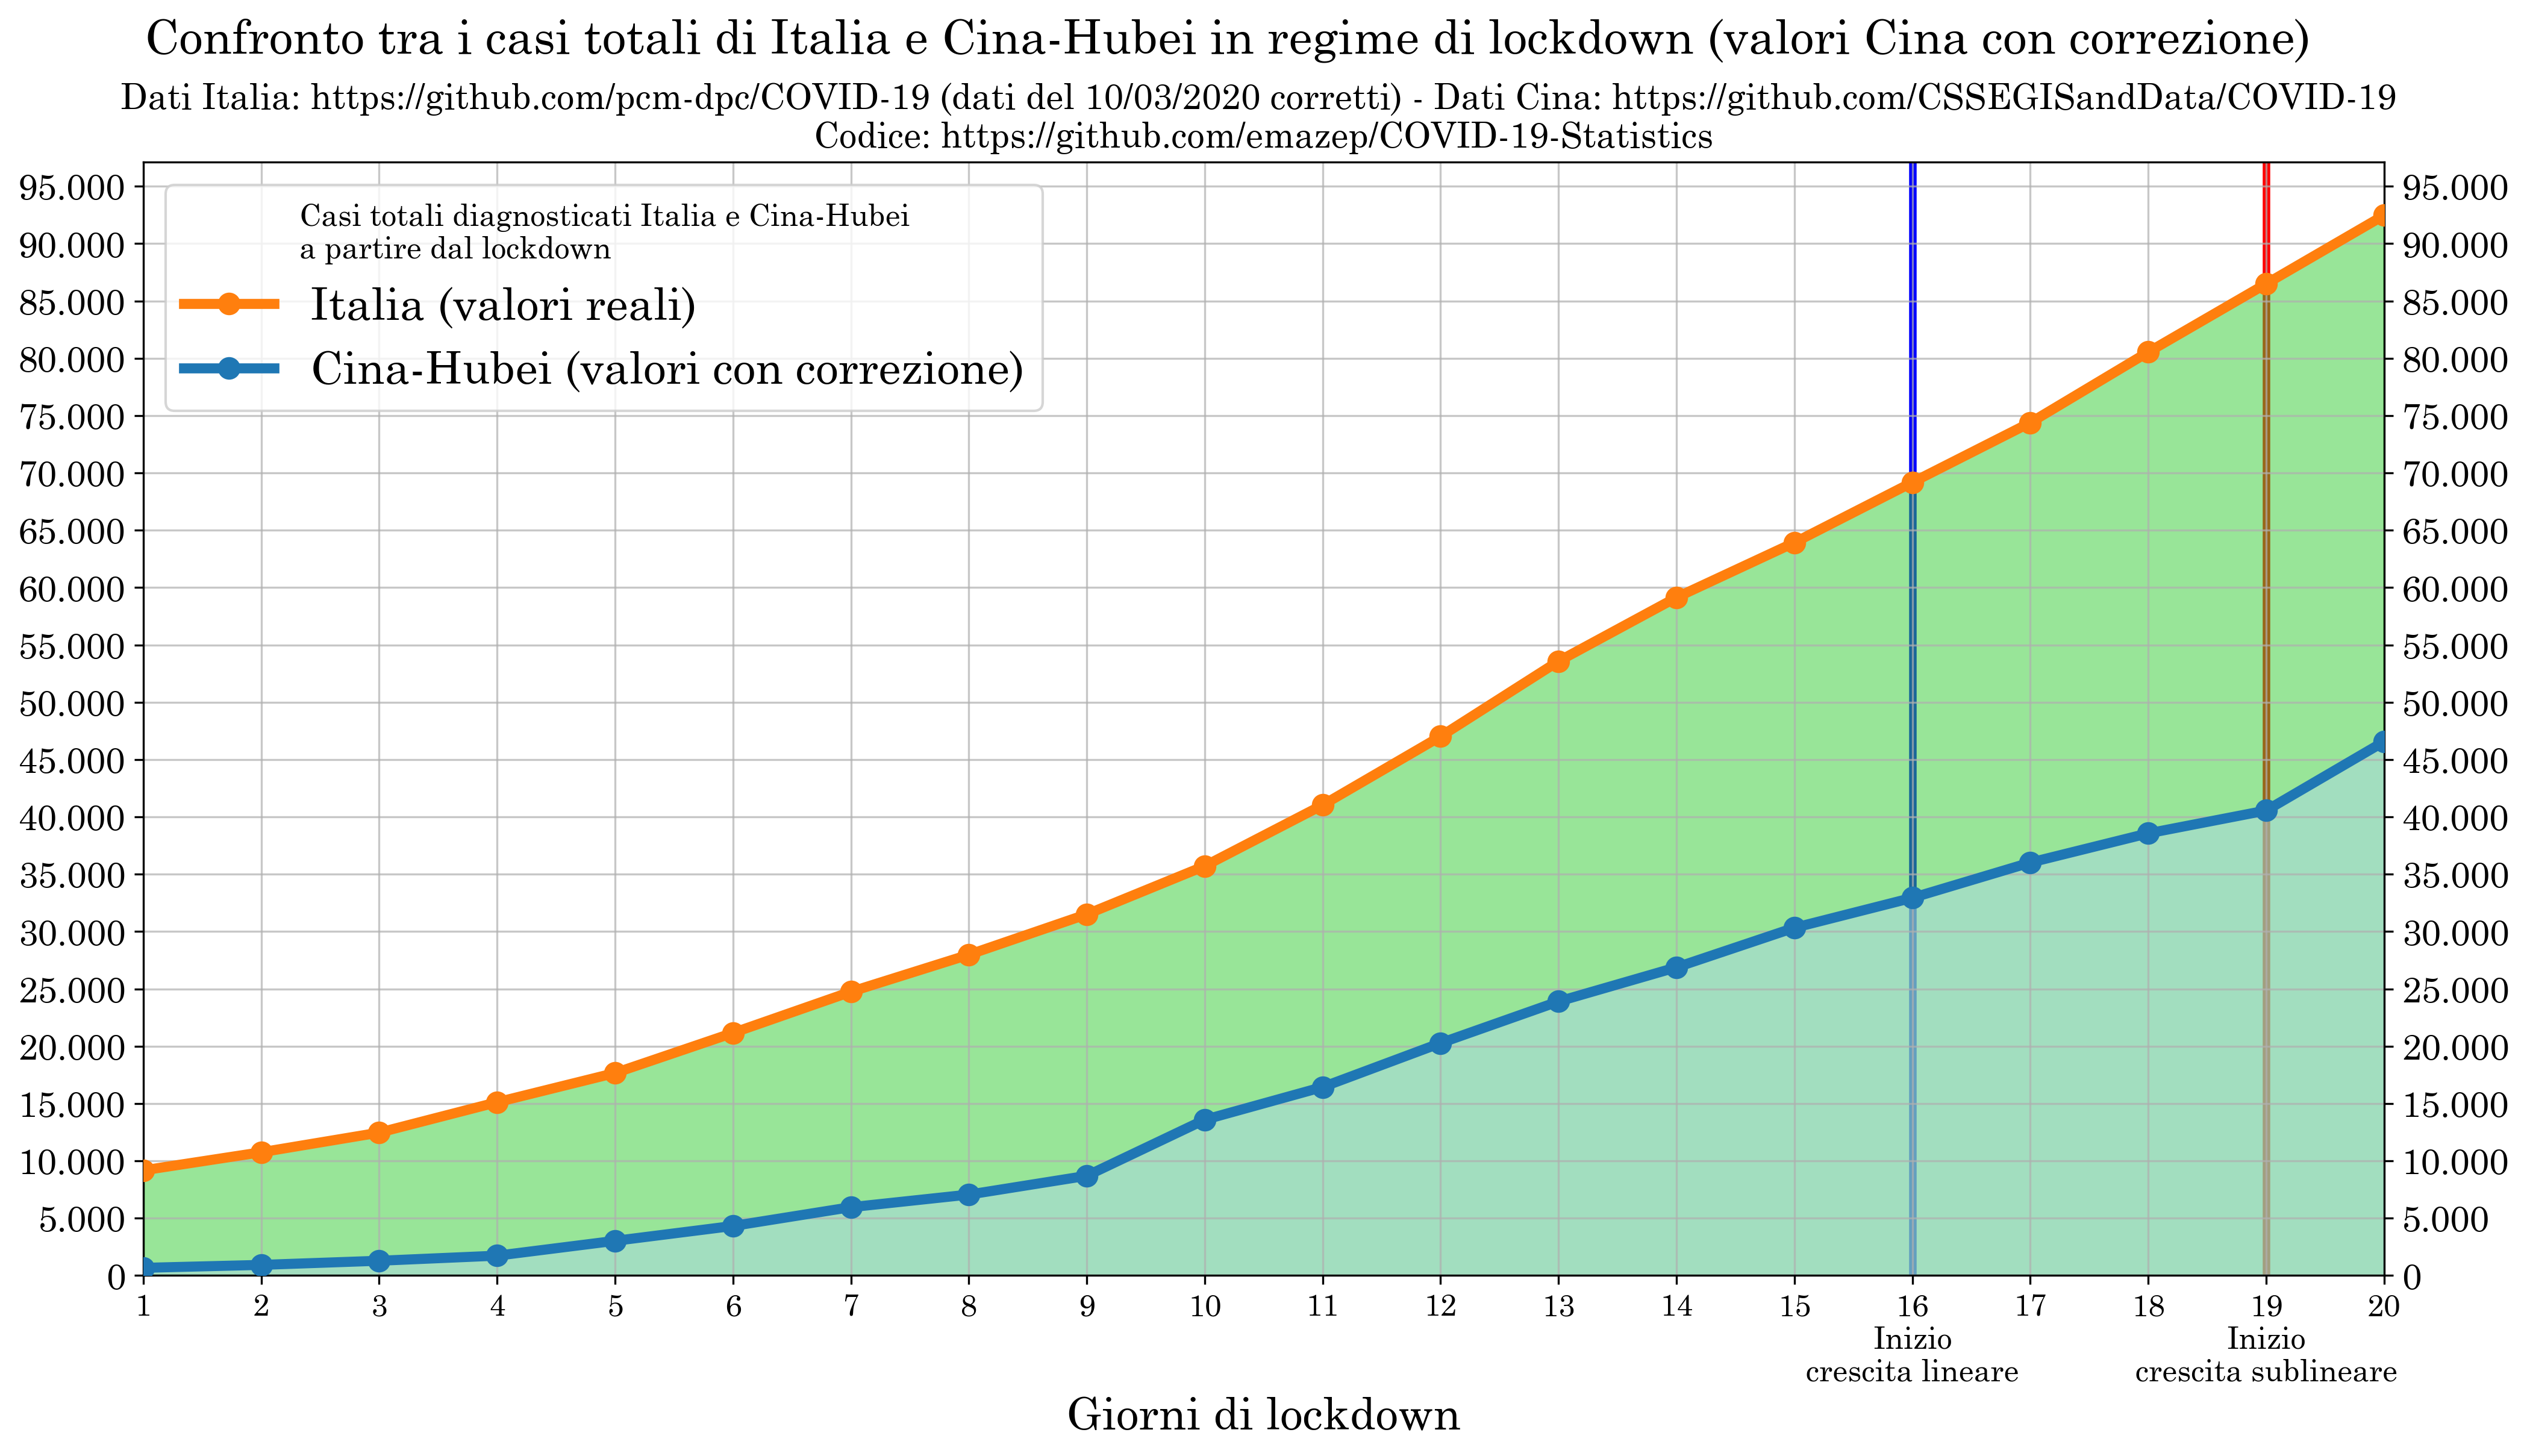

In [969]:
SLACK = 0.5
ALPHA = 0.7

ax = df_sided_plot_short.plot(
    y=['totale_casi_hubei_fixed', 'totale_casi'], label=['Cina-Hubei (valori con correzione)', 'Italia (valori reali)'], **common_plt_params, marker='o', figsize=(16, 8), zorder=3
)
plt.fill_between(df_sided_plot_short.index, df_sided_plot_short['totale_casi'], color='limegreen', alpha=0.5)
plt.fill_between(df_sided_plot_short.index, df_sided_plot_short['totale_casi_hubei_fixed'], color='lightblue', alpha=0.5)

ax.tick_params(axis='x', which='both', labelsize=12)
plt.xticks(range(1,21), list(range(1,16))+['16\nInizio\ncrescita lineare']+list(range(17,19))+['19\nInizio\ncrescita sublineare']+list(range(20,21)))
#ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax.yaxis.set_major_locator(ticker.MultipleLocator(5_000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax.tick_params(axis='y', which='both', labelsize=14)

ax.grid(which='both', alpha=ALPHA)
ax.tick_params(axis='y', which='both', right=True, labelright=True)

plt.axvline(x=16, linewidth=3, zorder=0, color='blue')
plt.axvline(x=19, linewidth=3, zorder=0, color='red')

plt.ylim(bottom=0)
plt.xlabel('Giorni di lockdown', fontsize=18)

ax.set_title(SUBTITLE, fontsize=14)
plt.suptitle('Confronto tra i casi totali di Italia e Cina-Hubei in regime di lockdown (valori Cina con correzione)', fontsize=19)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title="Casi totali diagnosticati Italia e Cina-Hubei\na partire dal lockdown", fontsize=18)

fig_ita_chn_corrected = plt.gcf()

plt.show()

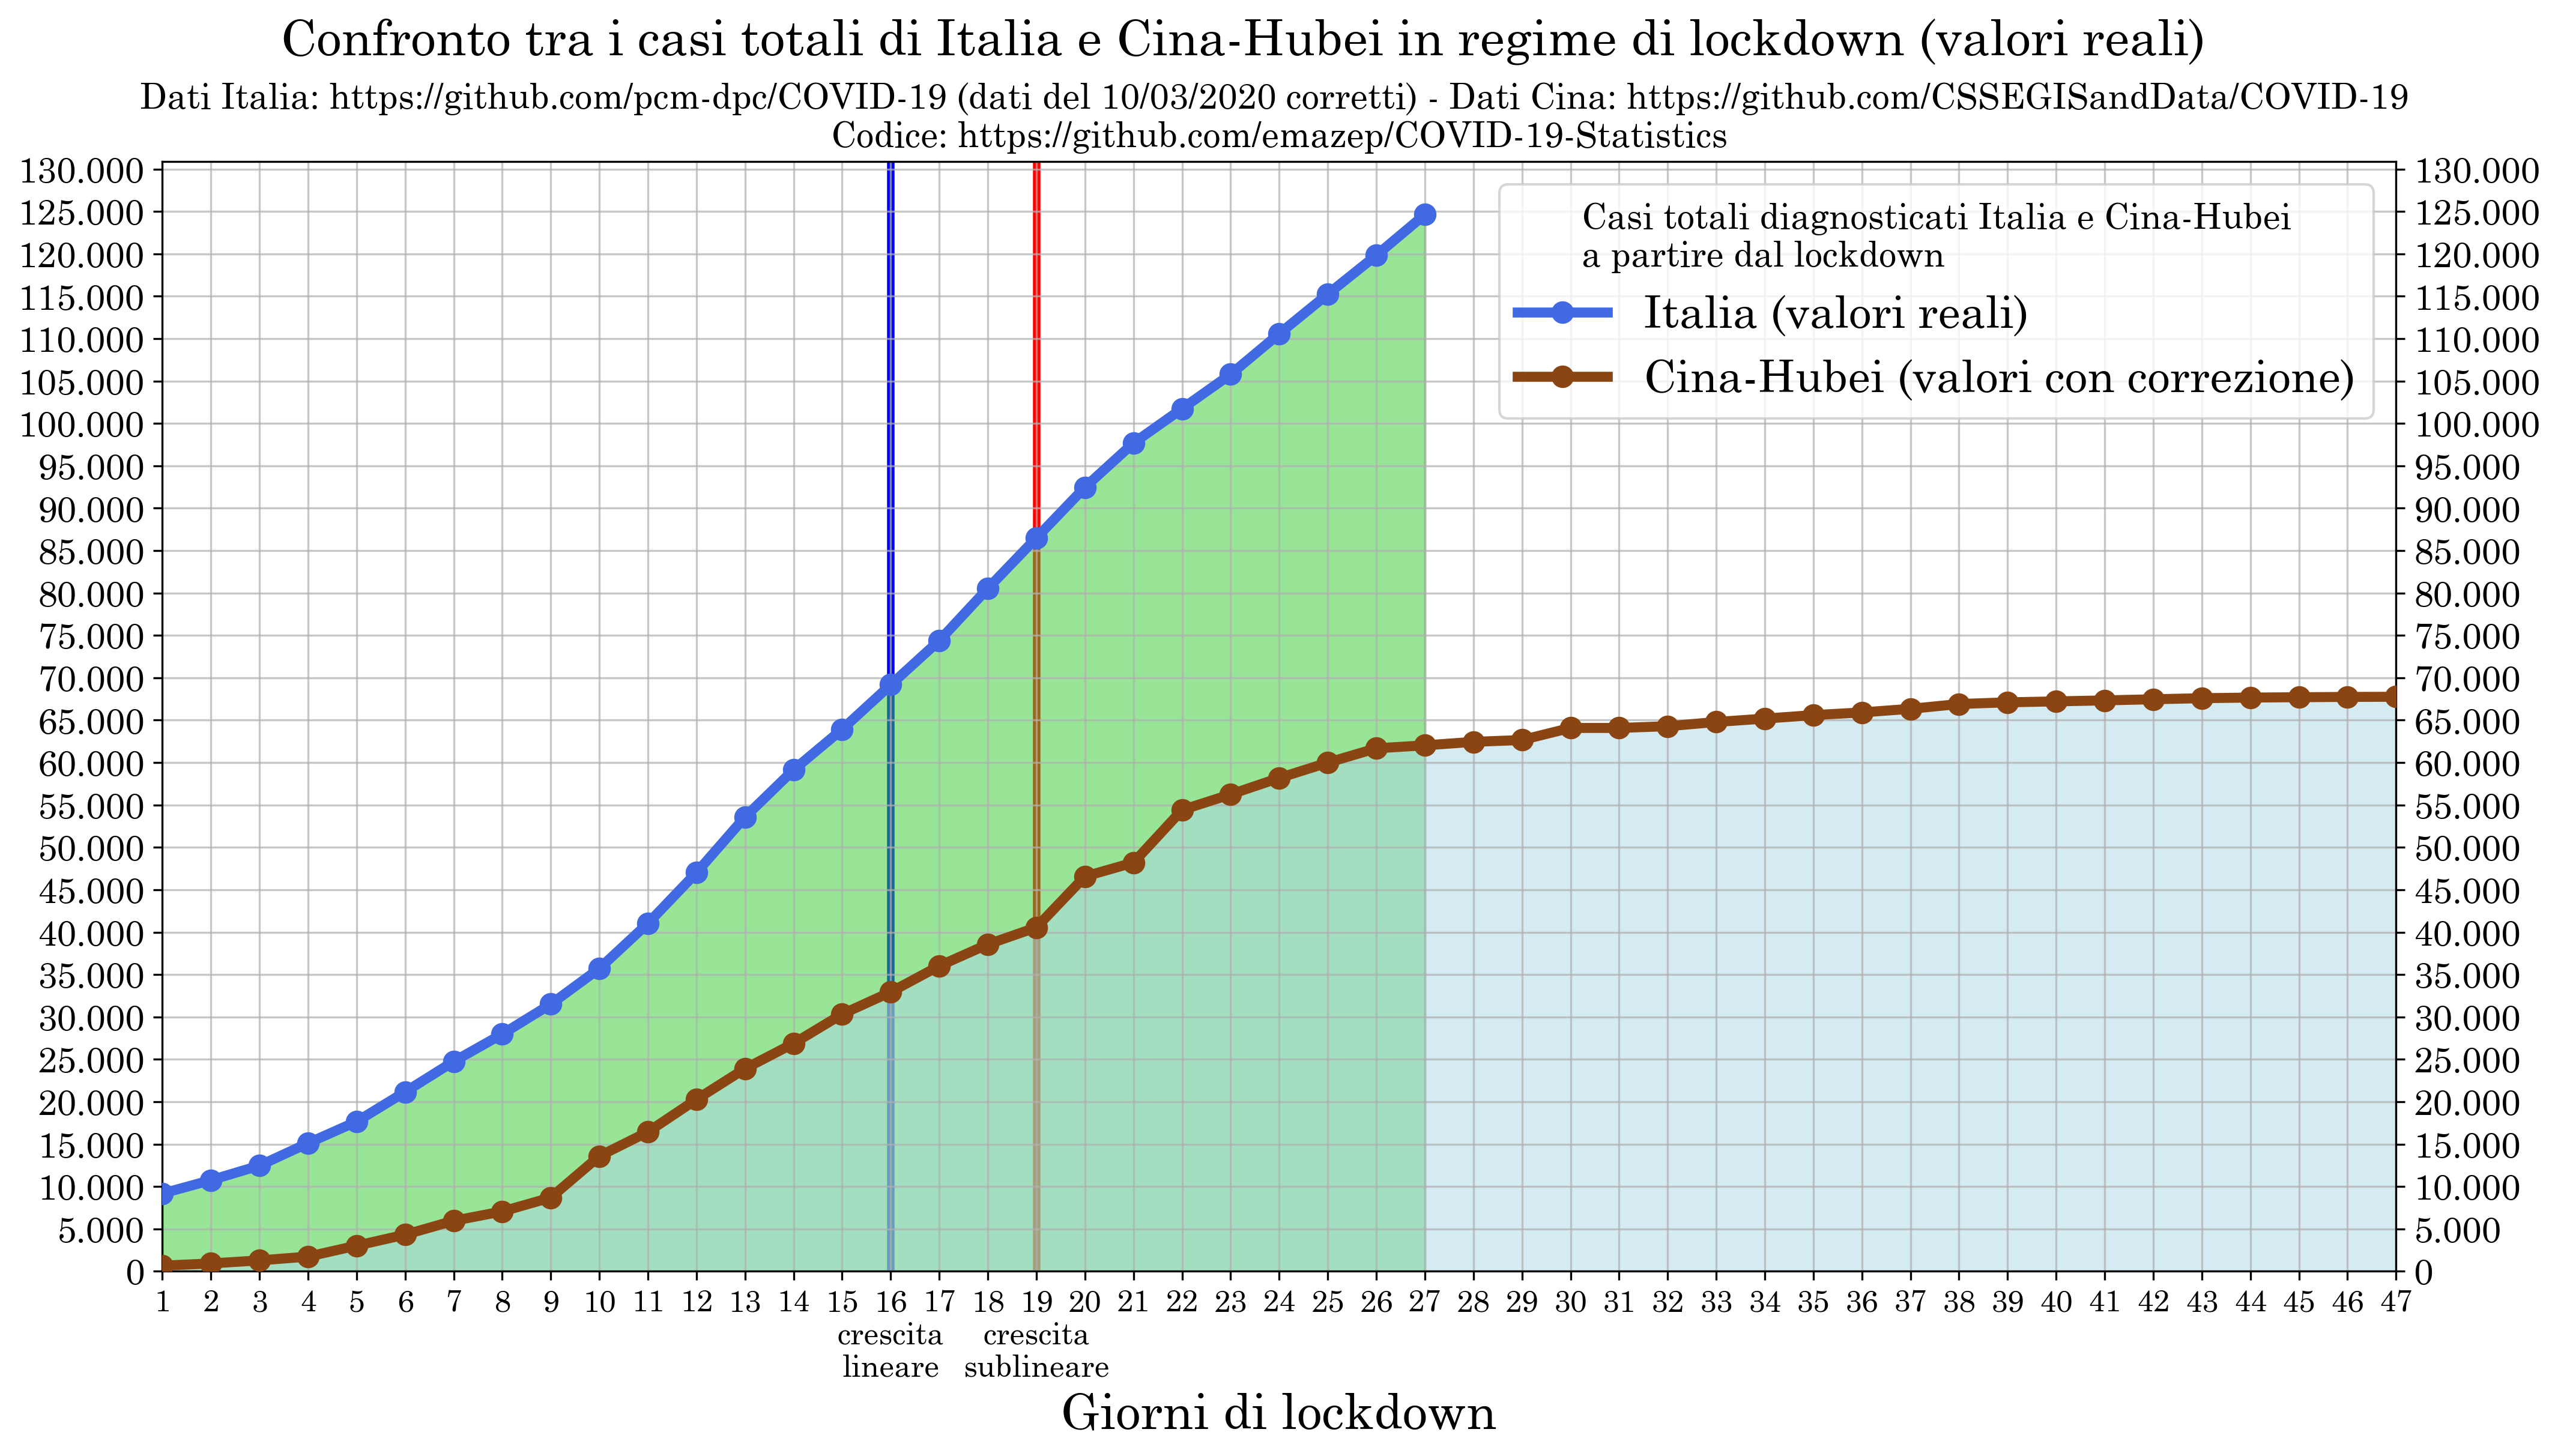

In [970]:
SLACK = 0.5
ALPHA = 0.7

plt.rcParams.update(mpl.rcParamsDefault)
set_plt_params()

ax = df_sided_plot_long.plot(
    y=['totale_casi', 'totale_casi_hubei_fixed'], label=['Italia (valori reali)', 'Cina-Hubei (valori con correzione)'],
    **common_plt_params, marker='o', figsize=(16, 8), color=['royalblue', 'saddlebrown'], zorder=3
)
plt.fill_between(df_sided_plot_long.index, df_sided_plot_long['totale_casi'], color='limegreen', alpha=0.5, zorder=1)
plt.fill_between(df_sided_plot_long.index, df_sided_plot_long['totale_casi_hubei_fixed'], color='lightblue', alpha=0.5, zorder=1)

ax.tick_params(axis='x', which='major', labelsize=12)
plt.xticks(
    range(1,57),
    list(range(1,16))  + ['16\ncrescita\nlineare']    +
    list(range(17,19)) + ['19\ncrescita\nsublineare'] +
    list(range(20,48))
)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax.yaxis.set_major_locator(ticker.MultipleLocator(5_000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax.tick_params(axis='y', which='both', labelsize=14)

ax.grid(which='both', alpha=ALPHA)
ax.tick_params(axis='y', which='both', right=True, labelright=True)

plt.axvline(x=16, linewidth=3, zorder=0, color='blue')
plt.axvline(x=19, linewidth=3, zorder=0, color='red')
#plt.axvline(x=22, linewidth=3, zorder=0, color='darkviolet')

plt.ylim(bottom=0)
plt.xlim(right=47)
plt.xlabel('Giorni di lockdown', fontsize=20)

ax.set_title(SUBTITLE, fontsize=14)
plt.suptitle('Confronto tra i casi totali di Italia e Cina-Hubei in regime di lockdown (valori reali)', fontsize=20)

handles, labels = ax.get_legend_handles_labels()
#ax.legend(reversed(handles), reversed(labels), title="Casi totali diagnosticati Italia e Cina-Hubei\na partire dal lockdown", fontsize=18)
ax.legend(title="Casi totali diagnosticati Italia e Cina-Hubei\na partire dal lockdown", fontsize=18)

fig_ita_chn = plt.gcf()

plt.show()

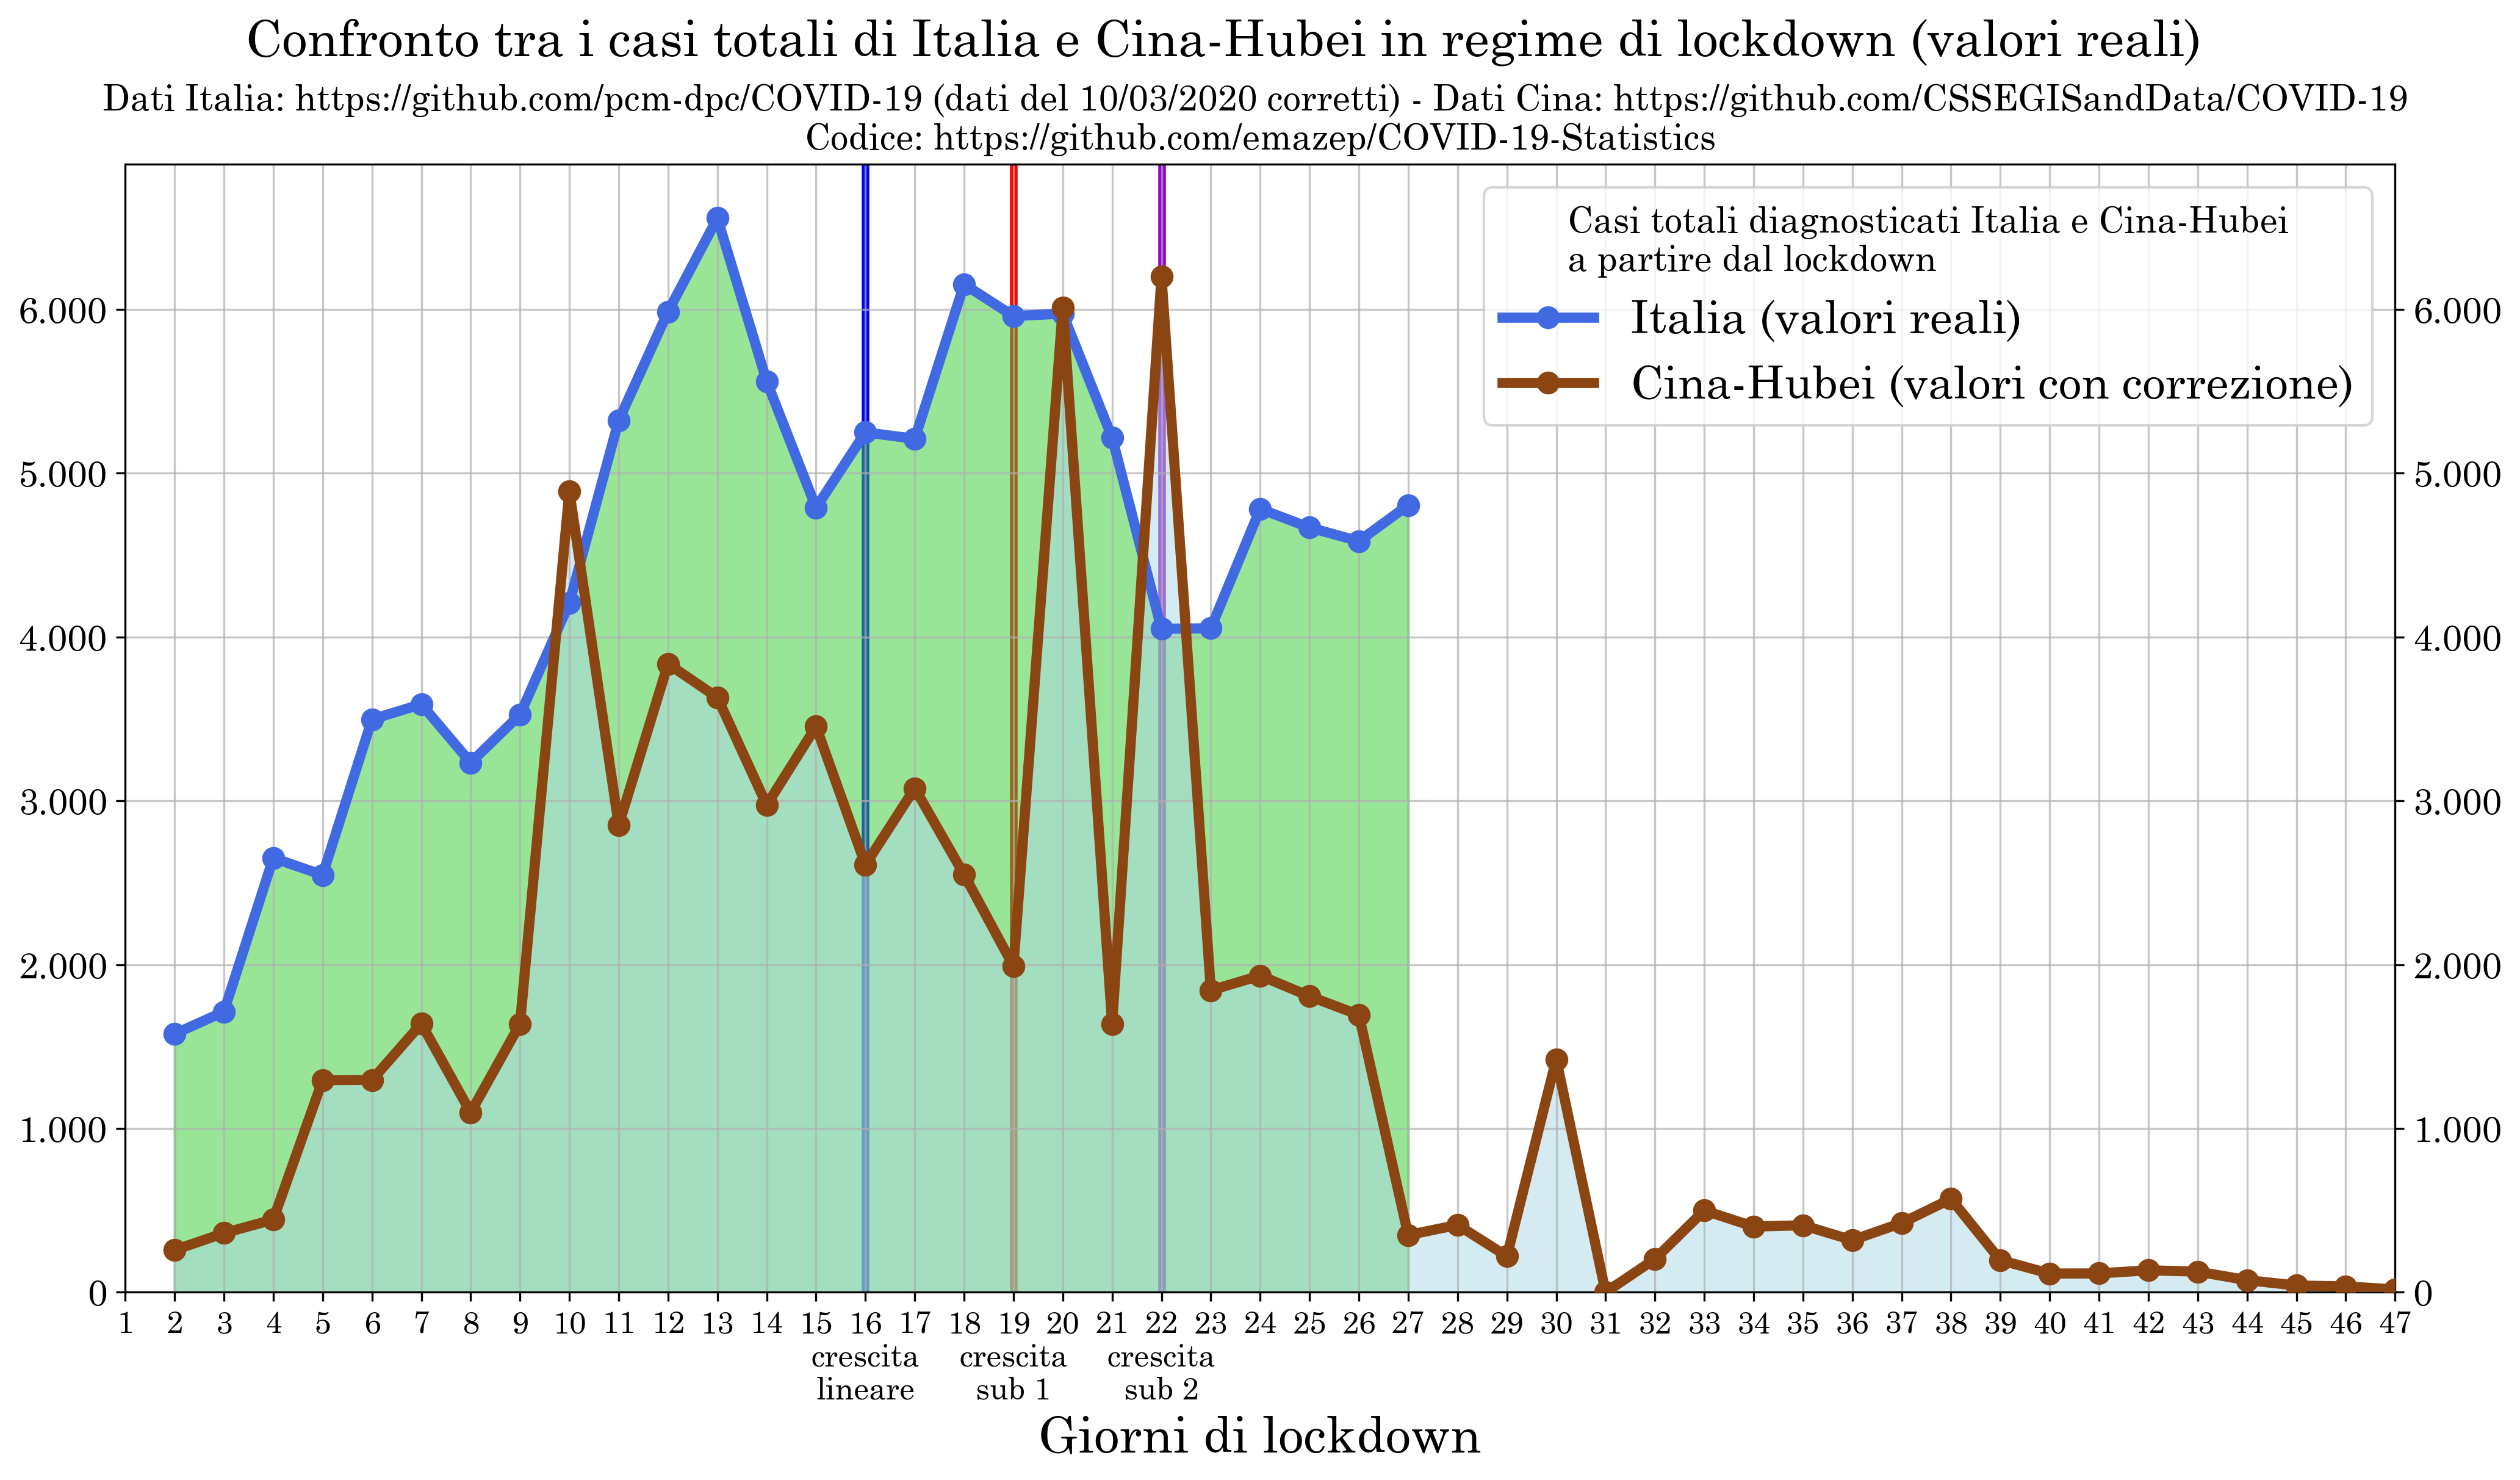

In [971]:
SLACK = 0.5
ALPHA = 0.7

ax = df_sided_plot_long.plot(
    y=['totale_casi_DELTA', 'totale_casi_hubei_fixed_DELTA'], label=['Italia (valori reali)', 'Cina-Hubei (valori con correzione)'],
    **common_plt_params, marker='o', figsize=(16, 8), color=['royalblue', 'saddlebrown'], zorder=3
)
plt.fill_between(df_sided_plot_long.index, df_sided_plot_long['totale_casi_DELTA'], color='limegreen', alpha=0.5, zorder=1)
plt.fill_between(df_sided_plot_long.index, df_sided_plot_long['totale_casi_hubei_fixed_DELTA'], color='lightblue', alpha=0.5, zorder=1)

ax.tick_params(axis='x', which='major', labelsize=12)
plt.xticks(range(1,57), list(range(1,16))+['16\ncrescita\nlineare']+list(range(17,19))+['19\ncrescita\nsub 1']+list(range(20,22))+['22\ncrescita\nsub 2']+list(range(23,57)))
#ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax.yaxis.set_major_locator(ticker.MultipleLocator(1_000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax.tick_params(axis='y', which='both', labelsize=14)

ax.grid(which='both', alpha=ALPHA)
ax.tick_params(axis='y', which='both', right=True, labelright=True)

plt.axvline(x=16, linewidth=3, zorder=0, color='blue')
plt.axvline(x=19, linewidth=3, zorder=0, color='red')
plt.axvline(x=22, linewidth=3, zorder=0, color='darkviolet')

plt.ylim(bottom=0)
plt.xlim(right=47)
plt.xlabel('Giorni di lockdown', fontsize=20)

ax.set_title(SUBTITLE, fontsize=14)
plt.suptitle('Confronto tra i casi totali di Italia e Cina-Hubei in regime di lockdown (valori reali)', fontsize=20)

handles, labels = ax.get_legend_handles_labels()
#ax.legend(reversed(handles), reversed(labels), title="Casi totali diagnosticati Italia e Cina-Hubei\na partire dal lockdown", fontsize=18)
ax.legend(title="Casi totali diagnosticati Italia e Cina-Hubei\na partire dal lockdown", fontsize=18)

fig_ita_chn = plt.gcf()

plt.show()

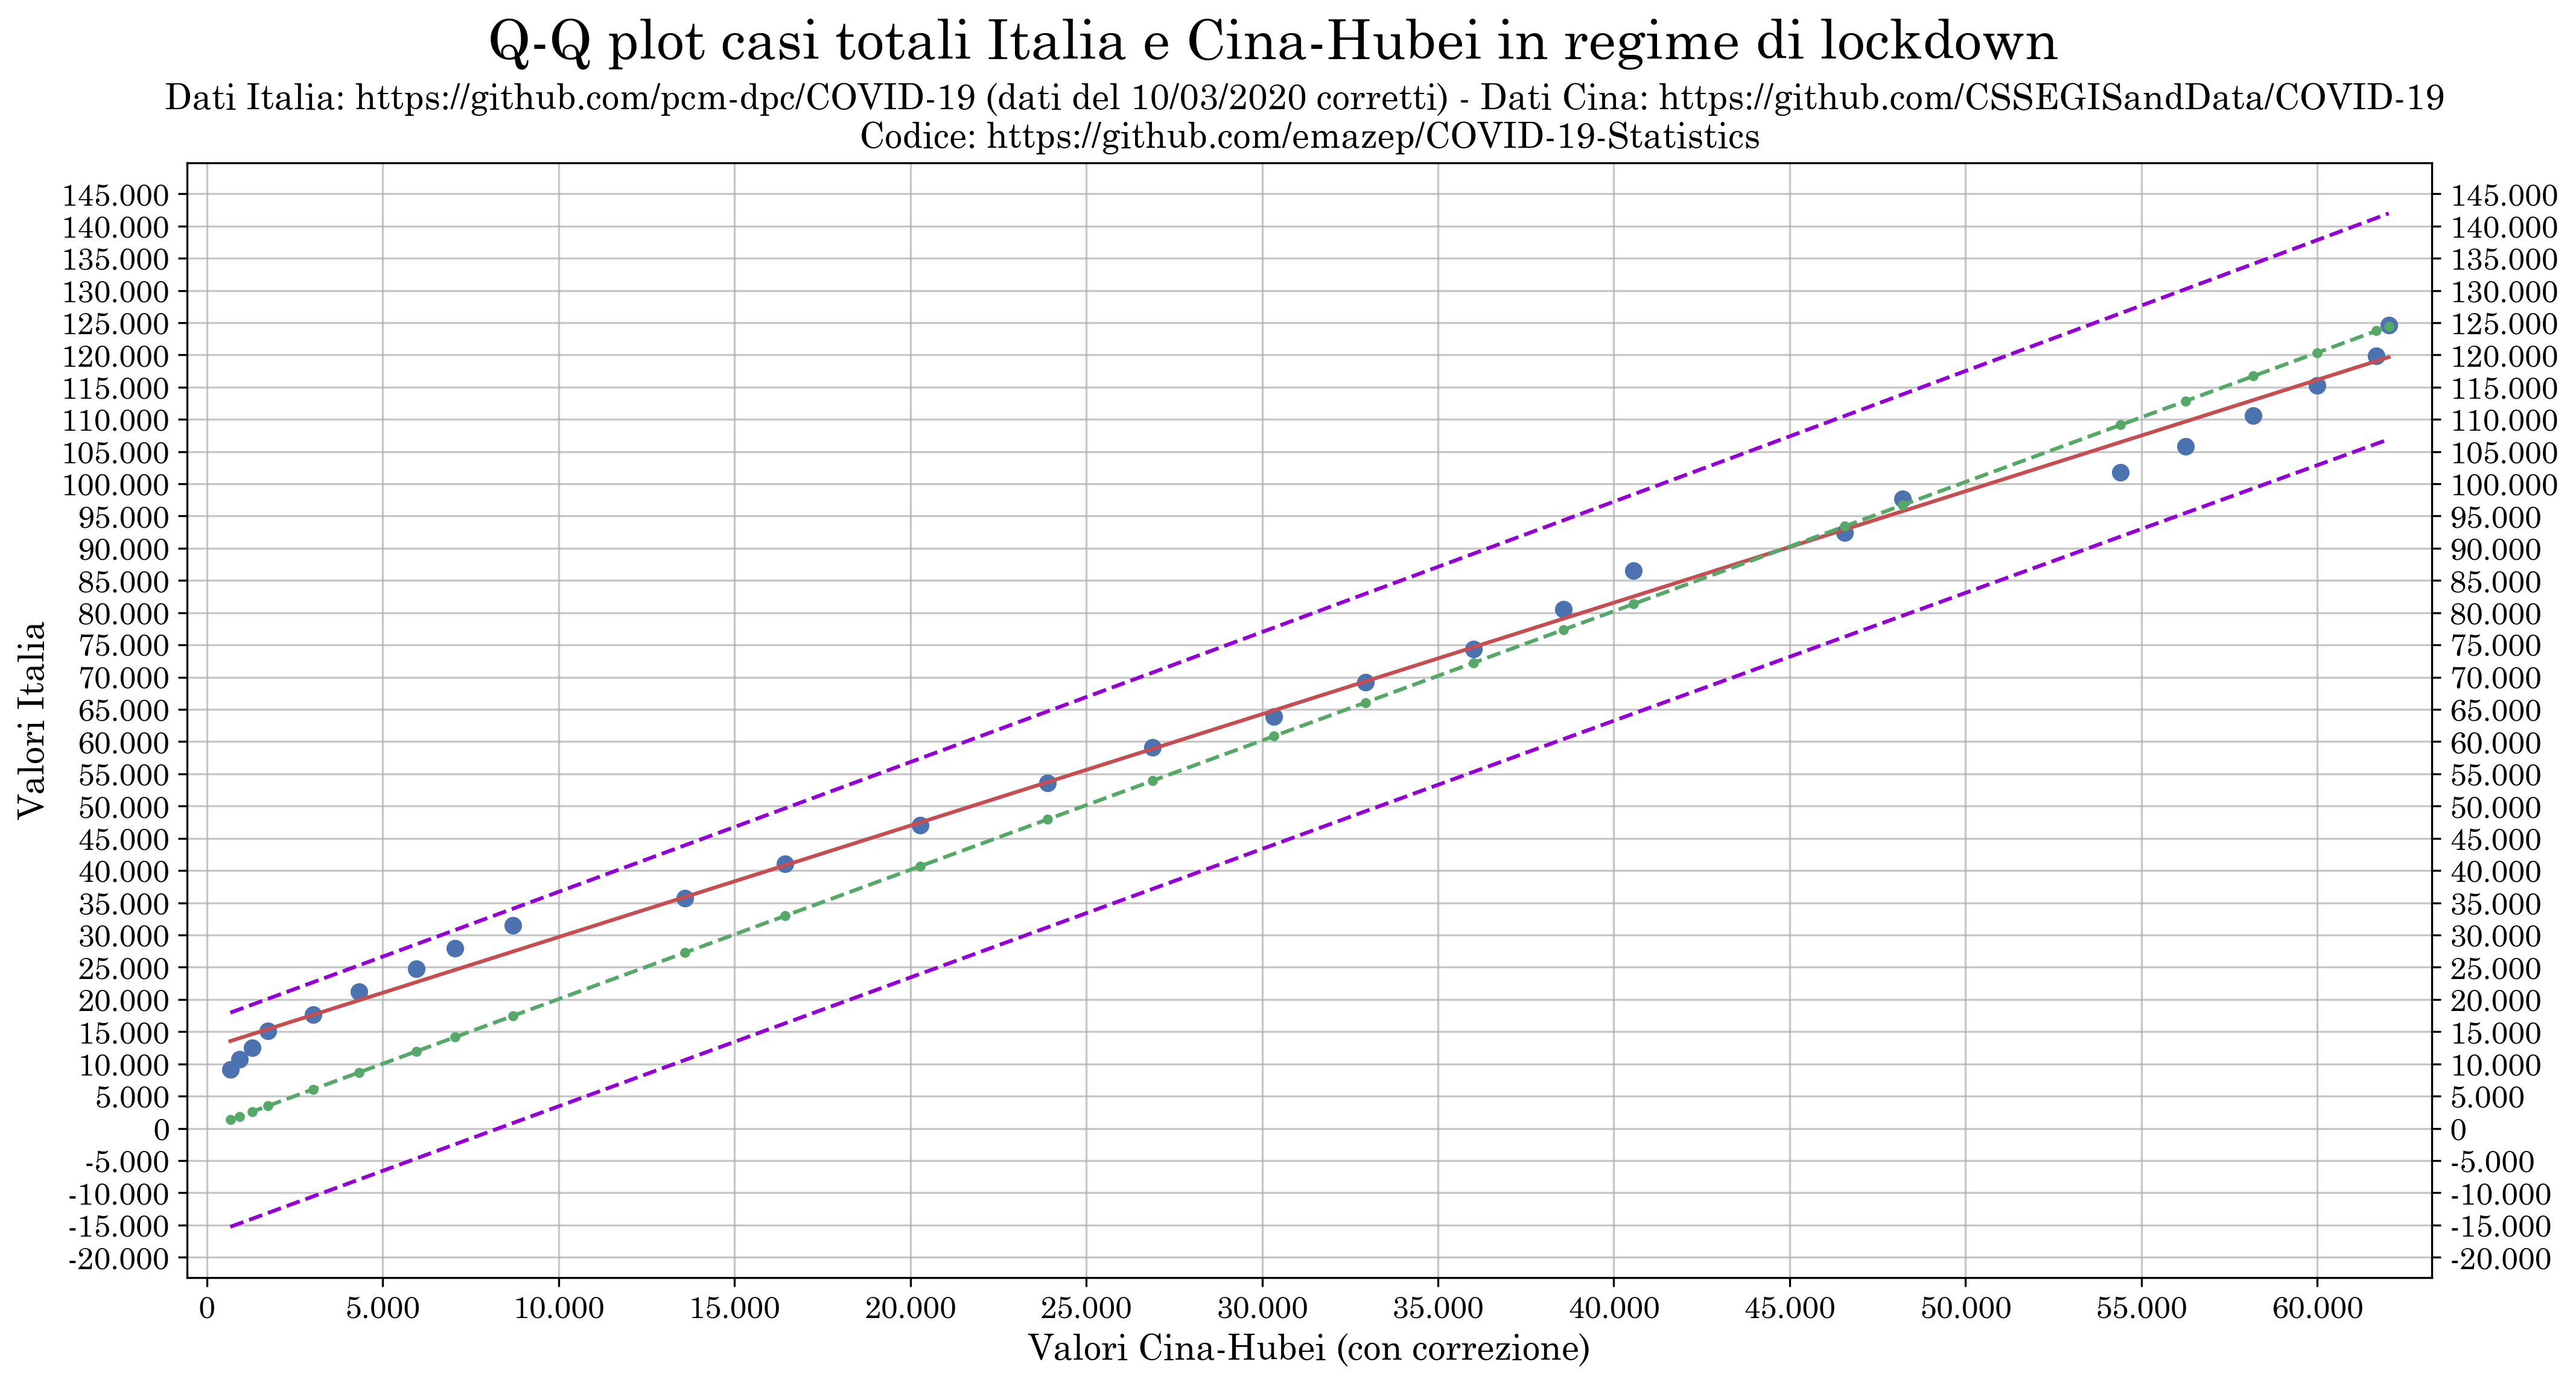

In [972]:
def format_number(x, p):
    return f'{int(x):,}'.replace(',', '.')

from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.sandbox.regression.predstd import wls_prediction_std

x = df_sided_plot_same_length['totale_casi']
y = df_sided_plot_same_length['totale_casi_hubei_fixed']
pp_x = sm.ProbPlot(x)
pp_y = sm.ProbPlot(y)

_, ax = plt.subplots(figsize=(16,8))

qqplot_2samples(pp_x, pp_y, line='r', xlabel='Valori Cina-Hubei (con correzione)', ylabel='Valori Italia', ax=ax)

x = df_sided_plot_same_length['totale_casi']
y = df_sided_plot_same_length['totale_casi_hubei_fixed']
# Fit and summarize OLS model
mod = sm.OLS(x, y)
reg = mod.fit()
prstd, iv_l, iv_u = wls_prediction_std(reg)
ax.plot(y, reg.fittedvalues, 'g--.', label="OLS")
ax.plot(y, iv_u, '--', color='darkviolet')
ax.plot(y, iv_l, '--', color='darkviolet')

ax.tick_params(axis='x', which='major', labelsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5_000))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_number))

ax.yaxis.set_major_locator(ticker.MultipleLocator(5_000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax.tick_params(axis='y', which='both', labelsize=12)

ax.grid(which='both', alpha=ALPHA)
ax.tick_params(axis='y', which='both', right=True, labelright=True)

ax.set_title(SUBTITLE, fontsize=14)
plt.suptitle('Q-Q plot casi totali Italia e Cina-Hubei in regime di lockdown', fontsize=22)

#ax.legend(title="Casi totali diagnosticati Italia e Cina-Hubei\na partire dal lockdown", fontsize=18)

fig_ita_chn = plt.gcf()

plt.show()

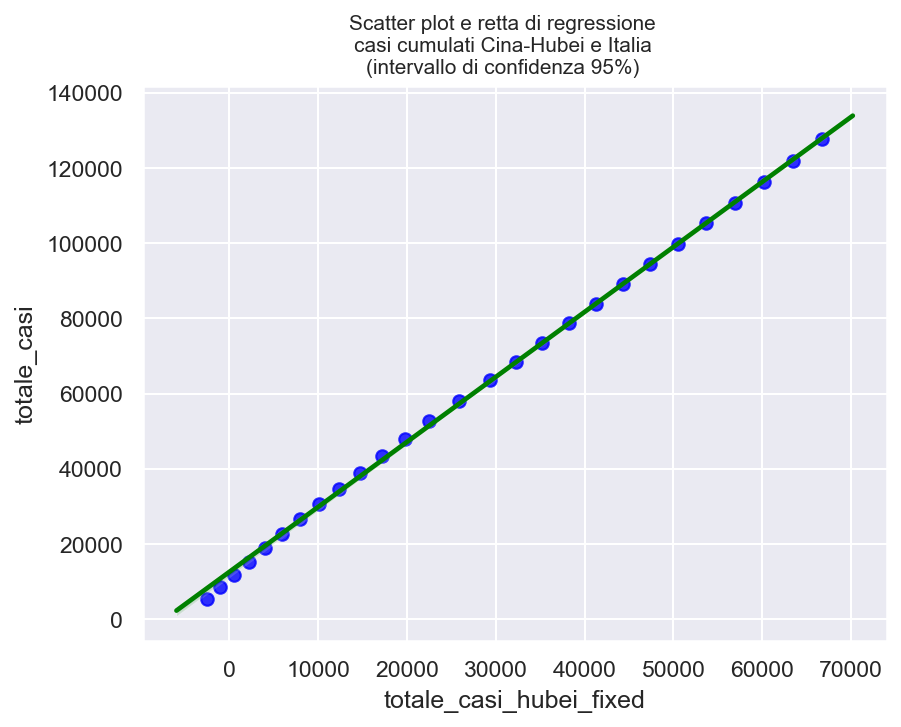

In [973]:
df_lr = df_sided_plot_same_length.loc[:, ['totale_casi', 'totale_casi_hubei_fixed']]

for column in ('totale_casi', 'totale_casi_hubei_fixed'):
    df_lr[column] = savgol_filter(df_lr[column], 25, 2)
    
import seaborn as sns

plt.rcParams.update(mpl.rcParamsDefault)
rcParams['figure.dpi'] = 150

sns.set(color_codes=True)

plt.xlabel('Casi cumulati Cina-Hubei', fontsize=12)
plt.ylabel('Casi cumulati Italia', fontsize=12)
plt.suptitle('Scatter plot e retta di regressione\ncasi cumulati Cina-Hubei e Italia\n(intervallo di confidenza 95%)', fontsize=10)

ax = sns.regplot(
    x='totale_casi_hubei_fixed', y='totale_casi', data=df_lr,
    ci=95, fit_reg=True, robust=True,
    color='green', scatter_kws={'color': 'blue'}, label='Regression plot'
)
#plt.show

<function matplotlib.pyplot.show(*args, **kw)>

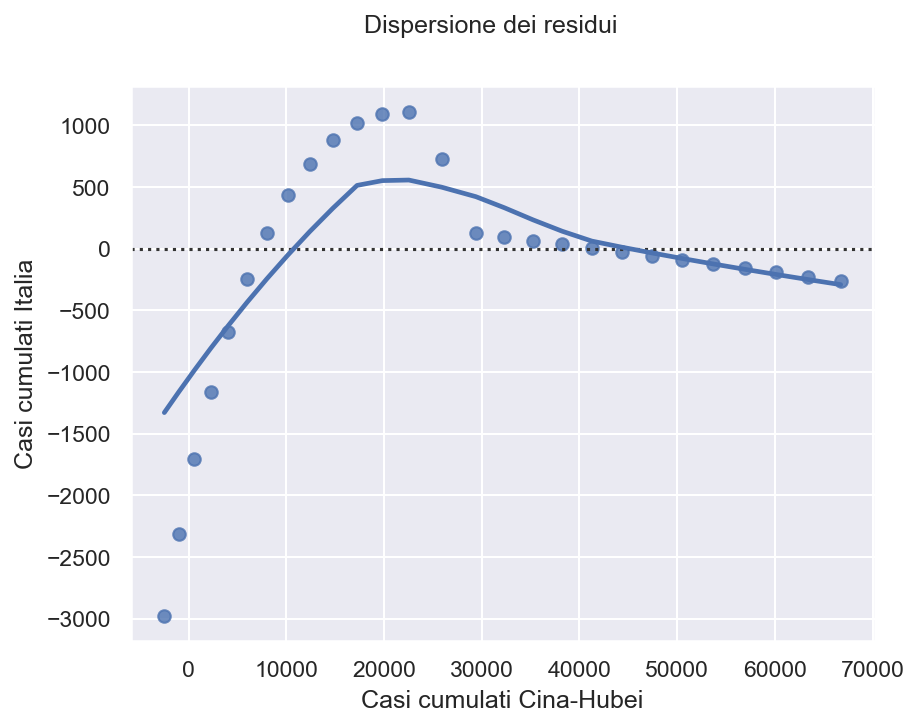

In [974]:
import seaborn as sns

plt.rcParams.update(mpl.rcParamsDefault)
rcParams['figure.dpi'] = 150

sns.set(color_codes=True)

sns.residplot(x='totale_casi_hubei_fixed', y='totale_casi', data=df_lr, lowess=True, robust=True)

plt.xlabel('Casi cumulati Cina-Hubei', fontsize=12)
plt.ylabel('Casi cumulati Italia', fontsize=12)
plt.suptitle('Dispersione dei residui', fontsize=12)
plt.show

In [975]:
y = df_lr['totale_casi'].values
x = df_lr['totale_casi_hubei_fixed'].values

#x_range = list(range(len(df_sided_plot_same_length.index)))
#x = np.column_stack((x_range, df_sided_plot_same_length['totale_casi_hubei_fixed'].values))
#y = df_sided_plot_same_length['totale_casi'].values

X = sm.add_constant(x)

weights = [x*10 for x in list(range(len(x)))]

mod = sm.GLS(y, X,  weights=weights)

reg = mod.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            GLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.989e+06
Date:                sab, 04 apr 2020   Prob (F-statistic):           1.45e-66
Time:                        18:43:58   Log-Likelihood:                -222.07
No. Observations:                  27   AIC:                             448.1
Df Residuals:                      25   BIC:                             450.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.21e+04    298.250     40.572      0.000    1.15e+04    1.27e+04
x1             1.7411      0.008    206.489      0.000       1.724       1.758
==============================================================================
Omnibus:                        3.094   Durbin-Watson:                   0.107
Prob(Omnibus):                  0.213   Jarque-Bera (JB):                1.761
Skew:                          -0.586   Prob(JB):                        0.415
Kurtosis:                       3.436   Cond. No.                     5.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [976]:
xnew = df_lr['totale_casi_hubei_fixed'].values
#xnew = df_sided_plot_long.loc[df_sided_plot_long.index>=22, 'totale_casi_hubei_fixed']

#x_range = list(range(len(df_sided_plot_long.index)))
#xnew = np.column_stack((x_range, df_sided_plot_long['totale_casi_hubei_fixed'].values))

xnew

array([-2480.93943057, -1015.51073882,   562.58704413,  2253.35391829,
        4056.78988365,  5972.89494022,  8001.66908799, 10143.11232697,
       12397.22465715, 14764.00607853, 17243.45659112, 19835.57619491,
       22540.36488991, 25894.48618127, 29408.06328424, 32318.73749072,
       35265.81654719, 38249.30045366, 41269.18921011, 44325.48281656,
       47418.18127299, 50547.28457942, 53712.79273584, 56914.70574225,
       60153.02359865, 63427.74630505, 66738.87386143])

In [977]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

Xnew = sm.add_constant(xnew)
#ynewpred =  reg.predict(Xnew)
#ynewpred = reg.get_prediction(Xnew)
df_lr['totale_casi_predicted'] = reg.predict(Xnew)
YY = reg.get_prediction(Xnew).summary_frame(alpha=0.05)
df_lr['totale_casi_predicted_2'] = YY['mean'].values
df_lr['mean_ci_lower'] = YY['mean_ci_lower'].values
df_lr['mean_ci_upper'] = YY['mean_ci_upper'].values
df_lr['obs_ci_lower'] = YY['obs_ci_lower'].values
df_lr['obs_ci_upper'] = YY['obs_ci_upper'].values

#df_lr['totale_casi_predicted_2'] = df_sided_plot_long['totale_casi_predicted_2'].shift()

#ynewpred.summary_frame()
#ynewpred.conf_int()
#wls_prediction_std(reg)

KeyError: 'obs_ci_lower'

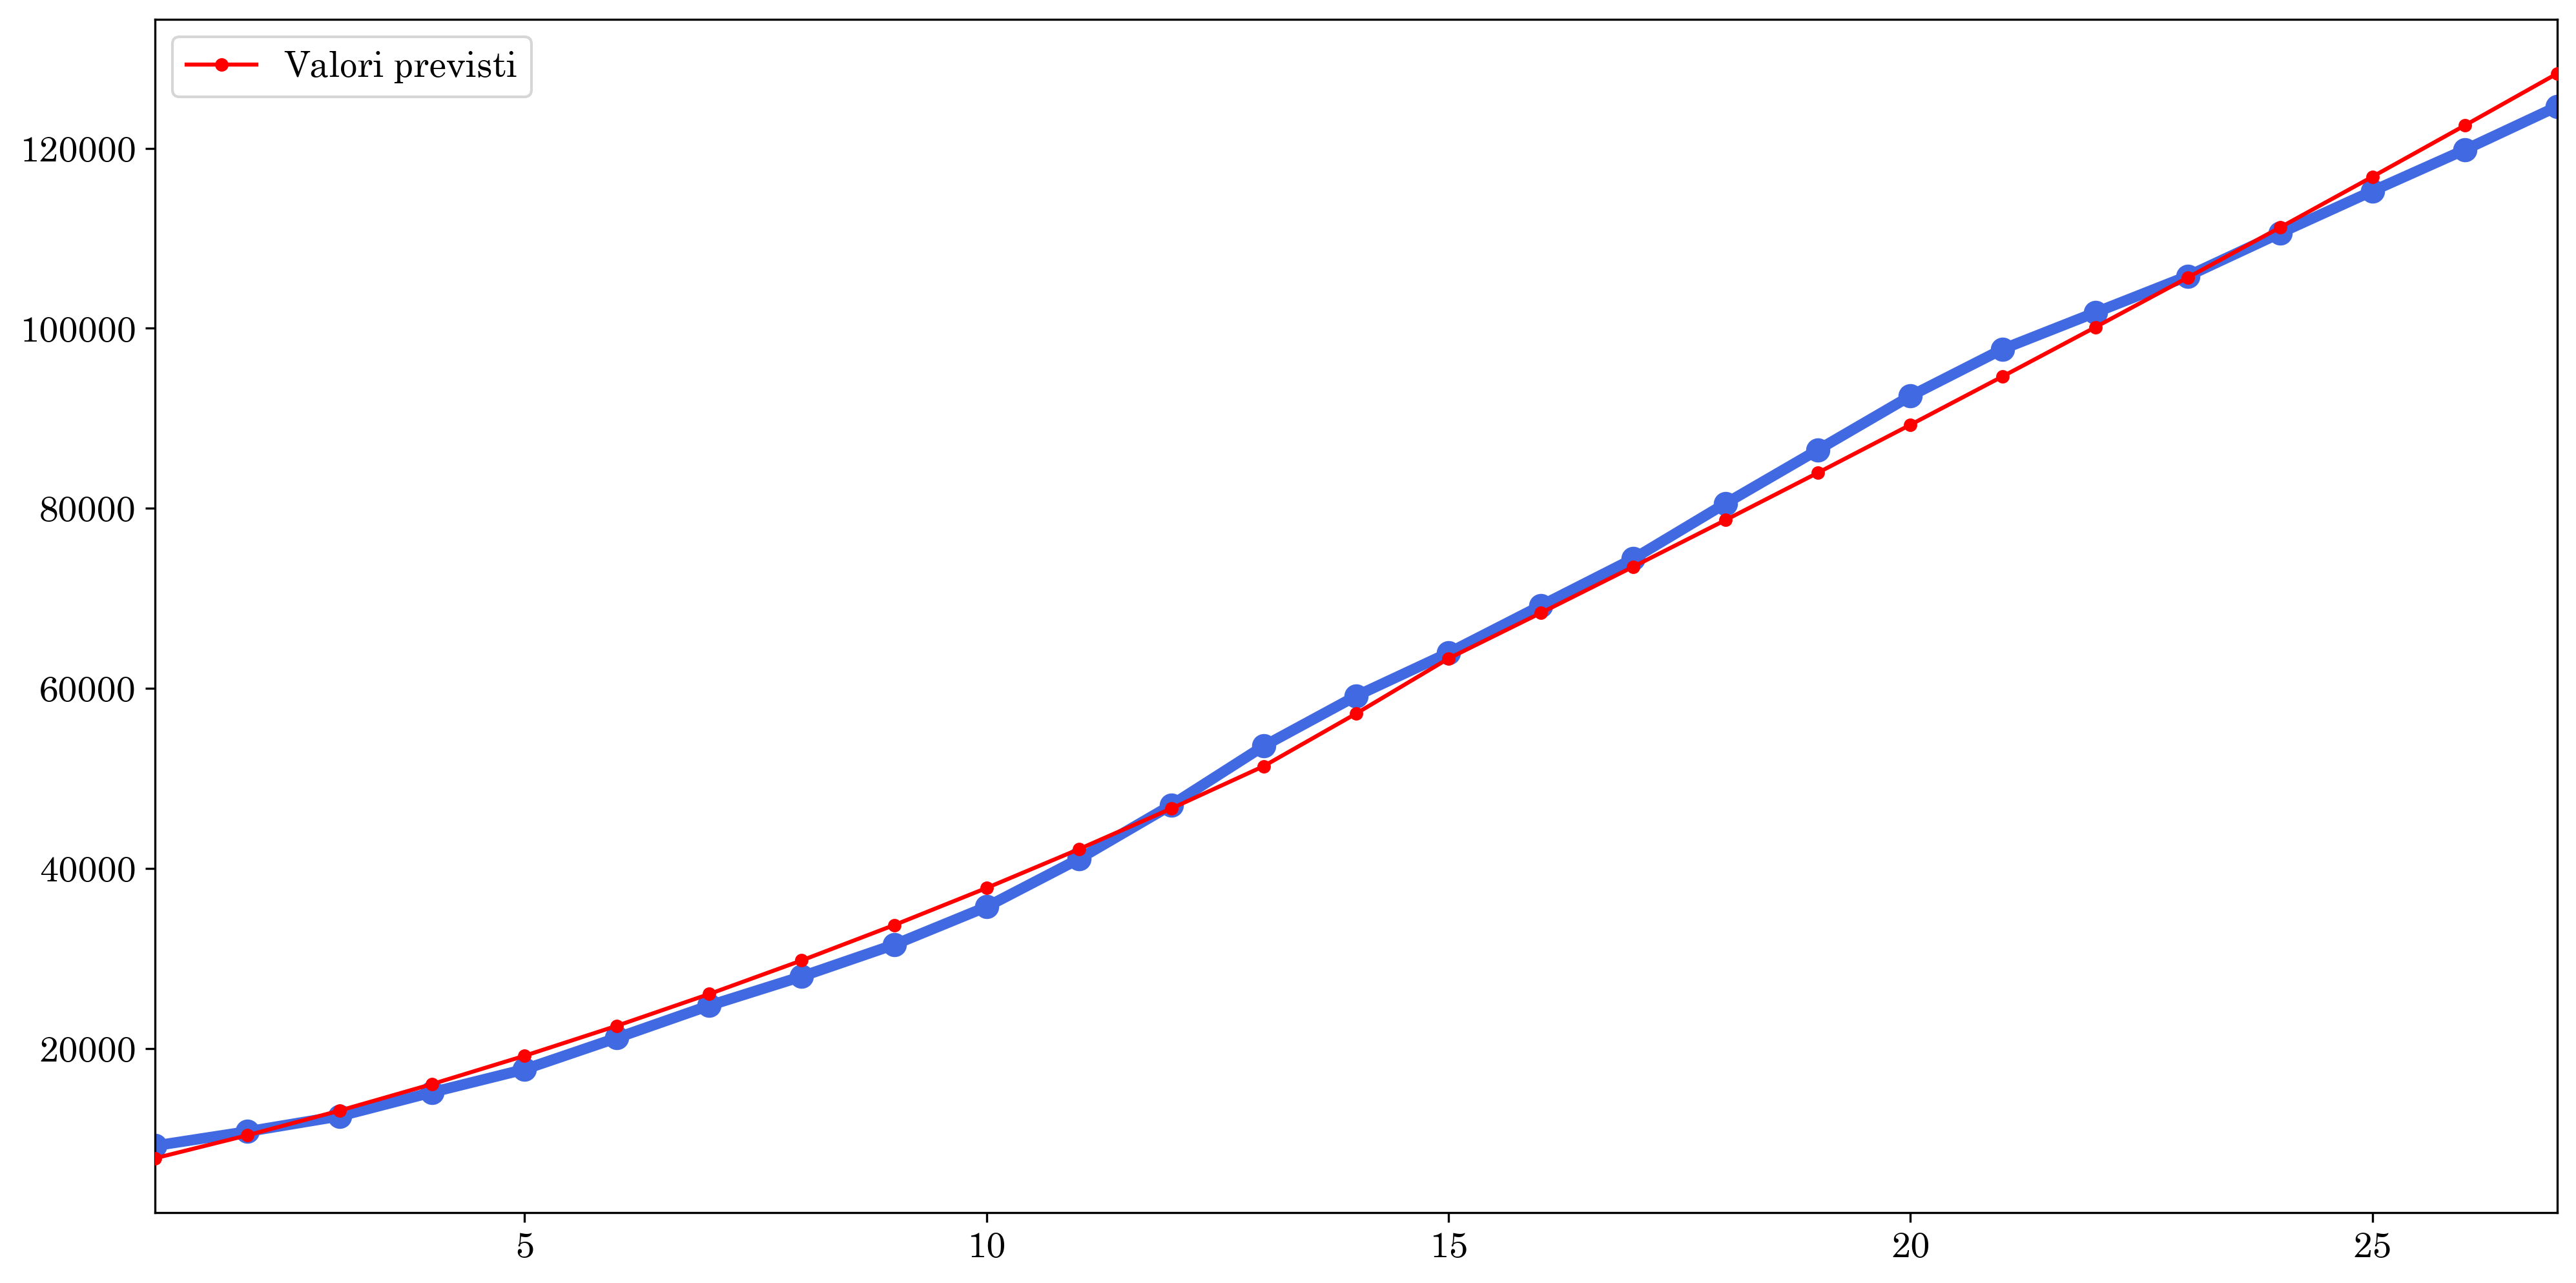

In [978]:
SLACK = 0.5
ALPHA = 0.5

plt.rcParams.update(mpl.rcParamsDefault)
set_plt_params()
rcParams['font.size'] = 13

ax = df_lr.plot(
    y='totale_casi_predicted_2', label='Valori previsti',
    linewidth=1.5, markersize=4, marker='o', figsize=(16, 8), color='red', zorder=4
)
ax.plot(df_sided_plot_long.index, df_sided_plot_long['totale_casi'], marker='o', color='royalblue', linewidth=4, markersize=8, label='Valori reali al 30/03/2020')
#ax.fill_between(df_sided_plot_long.index, df_sided_plot_long['totale_casi'], color='lightblue', alpha=0.7, zorder=0)
ax.fill_between(
    df_sided_plot_long.index, df_sided_plot_long['obs_ci_lower'], df_sided_plot_long['obs_ci_upper'],
    alpha=0.5, color='yellow', zorder=1, label='Intervallo di confidenza al 95%'
)
ax.plot(df_sided_plot_long.index, df_sided_plot_long['obs_ci_lower'], df_sided_plot_long['obs_ci_upper'], linewidth=0.7, color='k', zorder=1)

'''
plt.xticks(
    range(1,58),
    list(range(1,16))  + ['16\ncrescita\nlineare']            +
    list(range(17,19)) + ['19\ncrescita\nsub\nlineare\n1']    +
    list(range(20,22)) + ['22\ncrescita\nsub\nlineare\n2']    +
    list(range(23,54)) + ['54\nfine\nepidemia\n(01/05/2020)'] +
    list(range(56,58))
)
'''
plt.xticks(
    range(1,62),
    list(range(1,35))  + ['35\nPasqua'] +
    list(range(36,54)) + ['54\n01\nmaggio\n2020'] +
    list(range(55,60)) + ['60\n07\nmaggio\n2020']
)
ax.tick_params(axis='x', which='major', labelsize=10)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax.yaxis.set_major_locator(ticker.MultipleLocator(5_000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax.tick_params(axis='y', which='both', labelsize=11)

ax.grid(which='both', alpha=ALPHA)
ax.tick_params(axis='y', which='both', right=True, labelright=True)

#plt.axvline(x=16, linewidth=3, zorder=0, color='blue')
#plt.axvline(x=19, linewidth=3, zorder=0, color='red')
#plt.axvline(x=22, linewidth=3, zorder=0, color='darkviolet')
plt.axvline(x=35, linewidth=3.5, zorder=0, color='orange')
plt.axvline(x=54, linewidth=3.5, zorder=0, color='green')

plt.axvspan(54, 60, facecolor='limegreen', alpha=0.5)
plt.text(
    0.970, 0.5, 'Fine epidemia', horizontalalignment='right', verticalalignment='center', rotation='vertical', transform=ax.transAxes,
    fontsize=36, color='tab:red'
)

plt.ylim(bottom=0)
plt.xlim(right=60)
plt.xlabel('Giorni di lockdown', fontsize=20)

ax.set_title(SUBTITLE, fontsize=14)
plt.suptitle('Previsione casi diagnosticati cumulati Italia del 30/03/2020', fontsize=24)

sep = '\n———————————————'
handles, labels = ax.get_legend_handles_labels()
#ax.legend(reversed(handles), reversed(labels), title="Casi totali diagnosticati Italia e Cina-Hubei\na partire dal lockdown", fontsize=18)
ax.legend(
    title='Previsione casi totali Italia\n(regressione lineare dati Cina-Hubei)' + sep + '\nFine epidemia: 01/05/2020÷07/05/2020\nTotale casi finale: 123.978÷135.883' + sep,
    fontsize=14, loc='upper left'
)

fig_ita_chn = plt.gcf()

plt.show()

In [979]:
# Init df_it_fit from it original data
df_it_fit = ds_it.copy()

# Calculate DELTAs
df_it_fit['totale_casi_DELTA'] = df_it_fit['totale_casi'].diff()

# Get first date
first_date = df_it_fit.first_valid_index()
# Turn index into integers
df_it_fit.index = (df_it_fit.index - first_date).days
df_it_fit

stato  ricoverati_con_sintomi  terapia_intensiva  totale_ospedalizzati  \
0    ITA                     101                 26                   127   
1    ITA                     114                 35                   150   
2    ITA                     128                 36                   164   
3    ITA                     248                 56                   304   
4    ITA                     345                 64                   409   
5    ITA                     401                105                   506   
6    ITA                     639                140                   779   
7    ITA                     742                166                   908   
8    ITA                    1034                229                  1263   
9    ITA                    1346                295                  1641   
10   ITA                    1790                351                  2141   
11   ITA                    2394                462                  2856   
12   ITA                    2651                567                  3218   
13   ITA                    3557                650                  4207   
14   ITA                    4316                733                  5049   
15   ITA                    5038                877                  5915   
16   ITA                    5838               1028                  6866   
17   ITA                    6650               1153                  7803   
18   ITA                    7426               1328                  8754   
19   ITA                    8372               1518                  9890   
20   ITA                    9663               1672                 11335   
21   ITA                   11025               1851                 12876   
22   ITA                   12894               2060                 14954   
23   ITA                   14363               2257                 16620   
24   ITA                   15757               2498                 18255   
25   ITA                   16020               2655                 18675   
26   ITA                   17708               2857                 20565   
27   ITA                   19846               3009                 22855   
28   ITA                   20692               3204                 23896   
29   ITA                   21937               3396                 25333   
30   ITA                   23112               3489                 26601   
31   ITA                   24753               3612                 28365   
32   ITA                   26029               3732                 29761   
33   ITA                   26676               3856                 30532   
34   ITA                   27386               3906                 31292   
35   ITA                   27795               3981                 31776   
36   ITA                   28192               4023                 32215   
37   ITA                   28403               4035                 32438   
38   ITA                   28540               4053                 32593   
39   ITA                   28741               4068                 32809   
40   ITA                   29010               3994                 33004   

    isolamento_domiciliare  totale_positivi  variazione_totale_positivi  \
0                       94              221                           0   
1                      162              311                          90   
2                      221              385                          74   
3                      284              588                         203   
4                      412              821                         233   
5                      543             1049                         228   
6                      798             1577                         528   
7                      927             1835                         258   
8                     1000             2263                         428   
9                 

In [1051]:
from lmfit import Model
from scipy import special
import scipy.integrate as integrate

from lmfit.models import(
    GaussianModel, SkewedGaussianModel, LorentzianModel, ExponentialGaussianModel, StudentsTModel, Pearson7Model, MoffatModel,
    SplitLorentzianModel, VoigtModel, SkewedVoigtModel, LognormalModel, StepModel, RectangleModel, ExponentialModel, DonaichModel, BreitWignerModel
)

#model = SkewedGaussianModel()
#model = GaussianModel()
#model = LorentzianModel()
#model = SplitLorentzianModel()
#model = VoigtModel()
#model = LognormalModel()
#model = StepModel(form='logistic')
#model = ExponentialModel()
#model = Gompertz_CDF
#model = LogNormal_CDF

def Gompertz(x, amplitude, center, sigma):
    return amplitude * (1 - np.exp(-center*(np.exp(sigma*x)-1)))

def log_normal_CDF(x, amplitude, center, sigma):
    integrate(LognormalModel(amplitude, center, sigma), 0, x)

LogNormal_CDF = Model(log_normal_CDF)
Gompertz_CDF = Model(Gompertz)

model = BreitWignerModel()

In [1052]:
xvals_ext_CUM = np.arange(91)
xvals_ext_DELTA = np.arange(1, 91)
#yvals = df_it_fit['totale_casi_DELTA'][1:].to_numpy()

def totale_casi():
    yvals_orig = df_it_fit['totale_casi'][:].to_numpy()
    yvals = savgol_filter(yvals_orig, 23, 5)
    return df_it_fit.index[:].to_numpy(), yvals

def totale_positivi():
    yvals_orig = df_sided_plot_same_length['totale_positivi'][:].to_numpy()
    return savgol_filter(yvals_orig, 7, 2, mode='interp')

def totale_casi_DELTA():
    yvals_orig = df_it_fit['totale_casi_DELTA'][1:].to_numpy()
    return df_it_fit.index[1:].to_numpy(), xvals_ext_DELTA, savgol_filter(yvals_orig, 23, 2)
    #return df_it_fit.index[1:].to_numpy(), xvals_ext_DELTA, yvals_orig

xvals, xvals_ext, yvals = totale_casi_DELTA()

[[Model]]
    Model(breit_wigner)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4124
    # data points      = 40
    # variables        = 4
    chi-square         = 9612.88279
    reduced chi-square = 267.024522
    Akaike info crit   = 227.279199
    Bayesian info crit = 234.034717
[[Variables]]
    amplitude:  1.0084e-07 +/- 0.00219911 (2180834.37%) (init = 6000)
    center:     30.5930049 +/- 0.82014272 (2.68%) (init = 34)
    sigma:      15.8450247 +/- 2.09675723 (13.23%) (init = 10)
    q:         -255605.118 +/- 2.7678e+09 (1082856.90%) (init = 1)
    height:     6588.15835 +/- 996167.771 (15120.58%) == 'amplitude*q**2'
    fwhm:       15.8450247 +/- 2.09675721 (13.23%) == '2*(sqrt(q**2*sigma**2*(q**2+2))/max(2.220446049250313e-16, 2*(q**2)-2))'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, q)      =  1.000
    C(amplitude, sigma)  = -0.785
    C(sigma, q)          = -0.785
    C(center, q)         =  0.702
    C(amplitude,

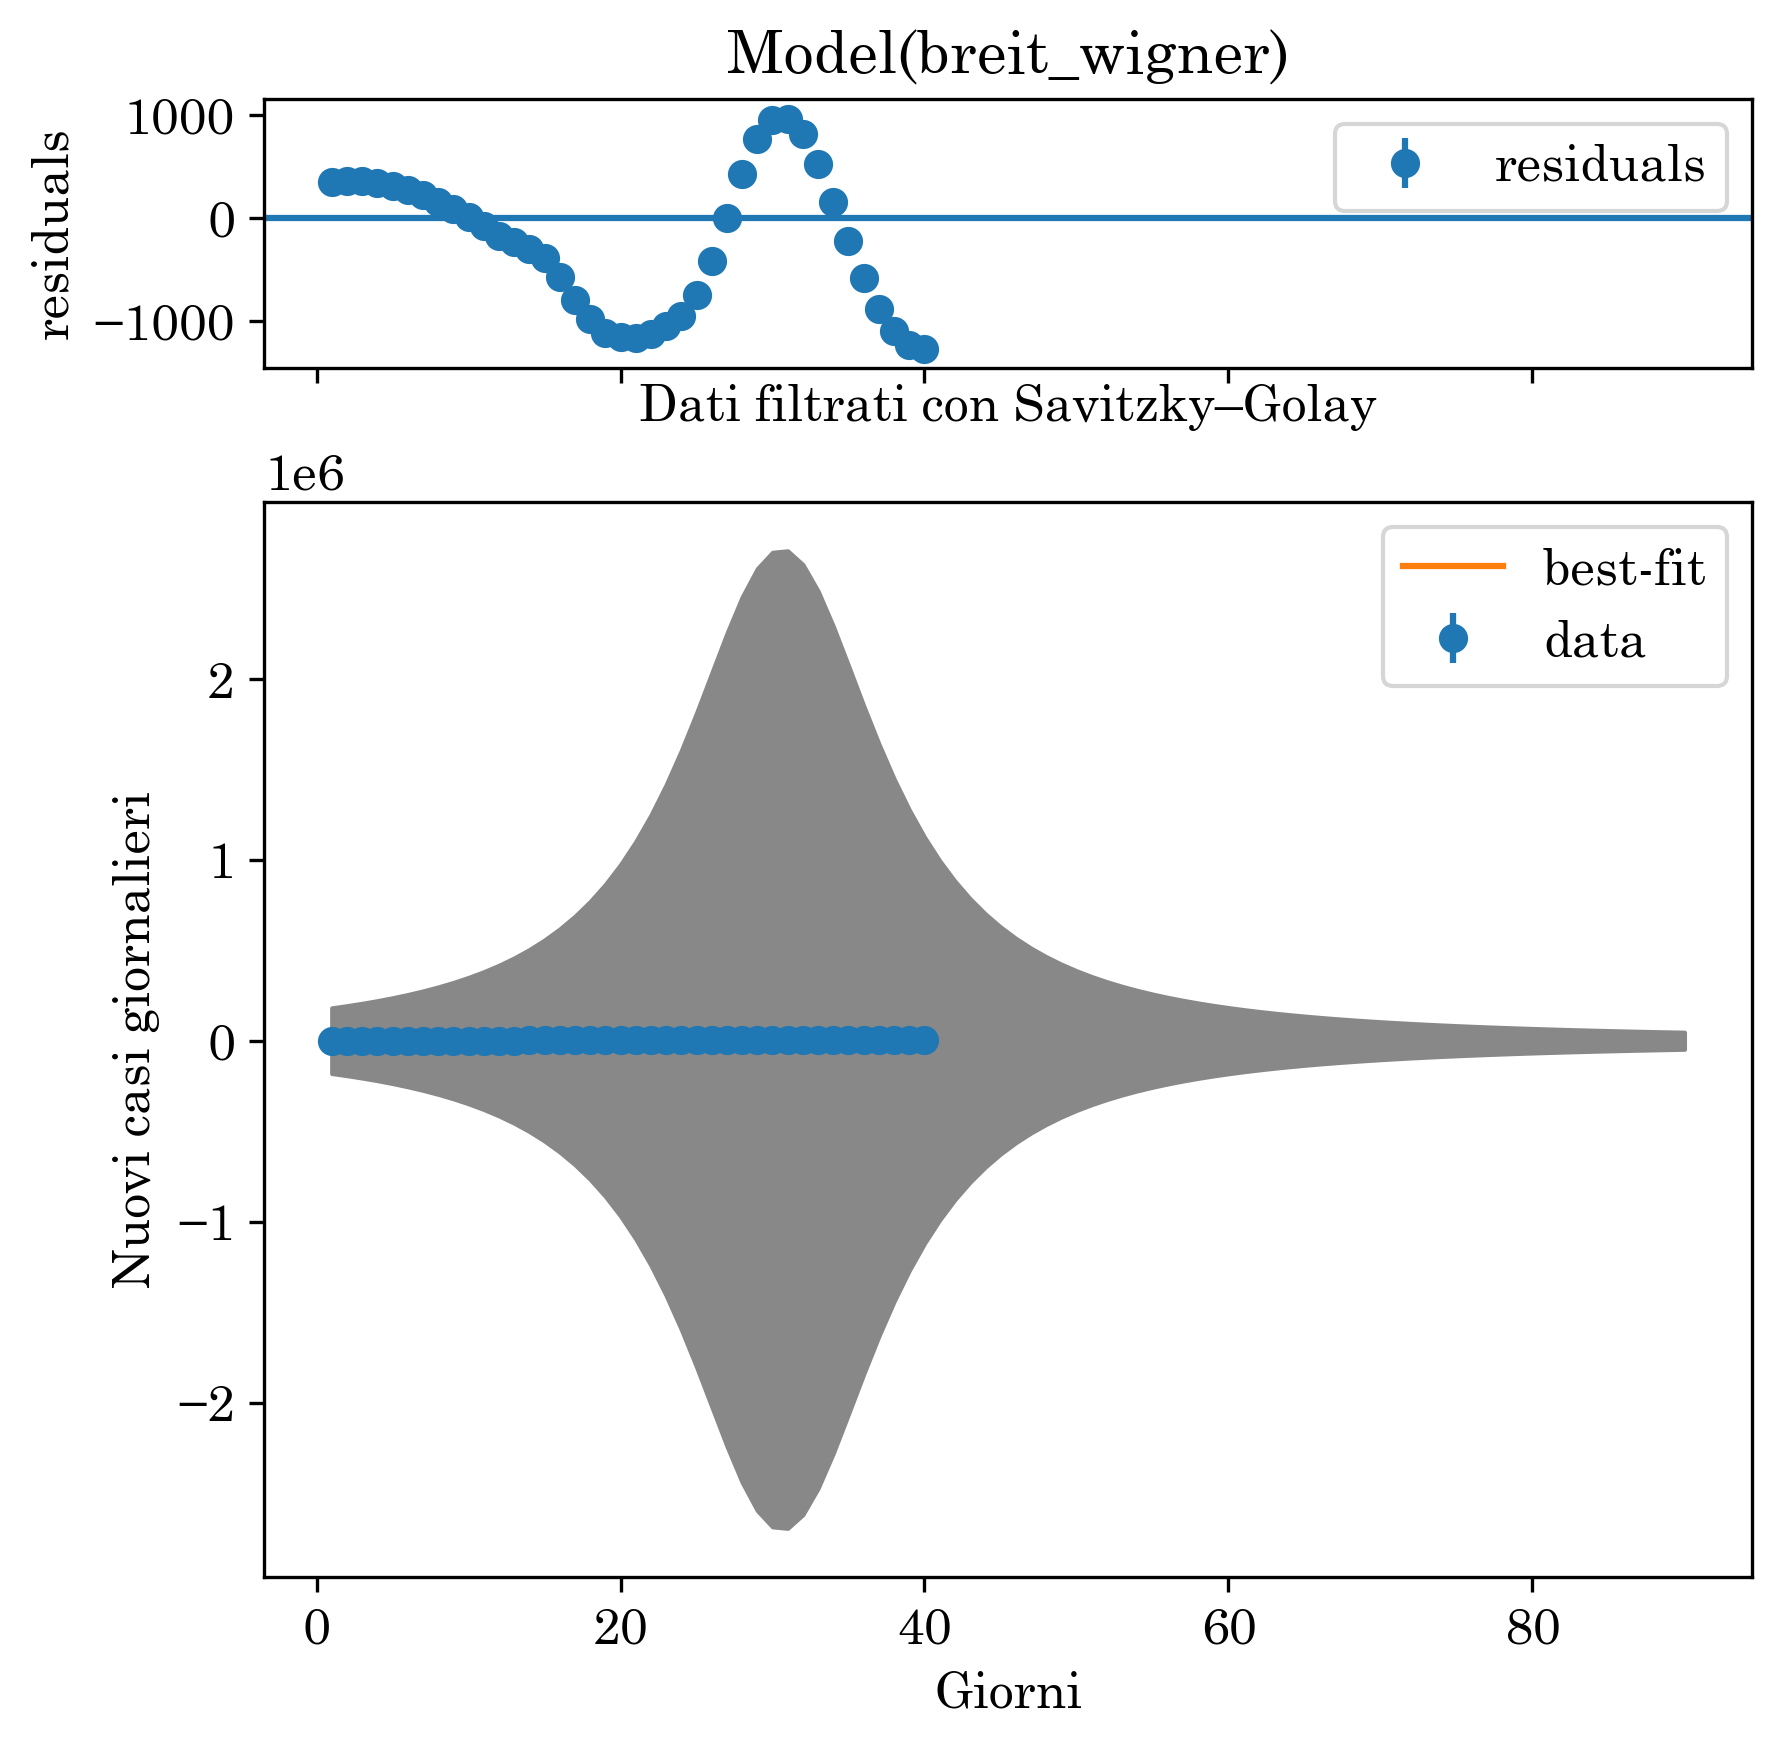

In [1053]:
# set initial parameter values
params = model.make_params(amplitude=6_000, center=34, sigma=10, gamma=-0.5)

# adjust parameters  to best fit data.
result = model.fit(yvals, params, x=xvals, weights=np.sqrt(1.0/yvals))
predicted_res = result.eval(x=xvals_ext)

print(result.fit_report())

#plt.plot(xvals, yvals, 'o', markersize=3, color='tab:red')
#plt.plot(xvals, result.best_fit, color='tab:blue')

result.plot(xlabel='Giorni', ylabel='Nuovi casi giornalieri', ax_res_kws={'xlabel': 'Dati filtrati con Savitzky–Golay'})

dely_res = result.eval_uncertainty(x=xvals_ext, sigma=0.99)

#plt.plot(xvals, data)

#plt.plot(xvals_ext, predicted)

plt.fill_between(xvals_ext, predicted_res-dely_res, predicted_res+dely_res, color='#888888')

fig_fit_report = plt.gcf()

plt.show()

In [1049]:
'''
# StepModel
predicted_DELTA = np.diff(predicted_res)
index_for_DELTA = df_sided_plot_long.index[1:]
dely_DELTA = dely/2
'''

# PeakModel
predicted_DELTA = predicted_res
predicted_CUM   = np.insert(predicted_res, 0, df_it_fit['totale_casi'].iloc[0])
predicted_CUM   = np.cumsum(predicted_CUM)

predicted_DELTA_index = xvals_ext
predicted_CUM_index   = xvals_ext_CUM

dely_DELTA = dely_res
dely_CUM   = np.insert(dely_res, 0, dely_res[0])

# Cast dely_DELTA over dely_CUM
it = np.nditer(dely_CUM, flags=['c_index'])
while not it.finished:
    i = it.index
    dely_CUM[i] *= np.sqrt(i+1)
    it.iternext()

In [950]:
min_date = date.fromisoformat('2020-04-25')
for value in predicted_DELTA
    if value < 10:

it = np.nditer(predicted, flags=['c_index'])
while not it.finished:
    i = it.index
    dely_CUM[i] *= np.sqrt(i+1)
    it.iternext()

array([9.56236932e+01, 1.25882500e+02, 1.64140140e+02, 2.11989247e+02,
       2.71182998e+02, 3.43605949e+02, 4.31229521e+02, 5.36050724e+02,
       6.60013595e+02, 8.04913977e+02, 9.72289619e+02, 1.16329918e+03,
       1.37859528e+03, 1.61819831e+03, 1.88137901e+03, 2.16655858e+03,
       2.47123571e+03, 2.79194912e+03, 3.12428339e+03, 3.46292378e+03,
       3.80176298e+03, 4.13405962e+03, 4.45264453e+03, 4.75016733e+03,
       5.01937200e+03, 5.25338769e+03, 5.44601850e+03, 5.59201548e+03,
       5.68731405e+03, 5.72922197e+03, 5.71654569e+03, 5.64964686e+03,
       5.53042514e+03, 5.36222862e+03, 5.14969759e+03, 4.89855197e+03,
       4.61533581e+03, 4.30713500e+03, 3.98128488e+03, 3.64508465e+03,
       3.30553358e+03, 2.96910203e+03, 2.64154652e+03, 2.32777498e+03,
       2.03176429e+03, 1.75652866e+03, 1.50413477e+03, 1.27575669e+03,
       1.07176249e+03, 8.91823353e+02, 7.35036188e+02, 6.00051043e+02,
       4.85196055e+02, 3.88593847e+02, 3.08264967e+02, 2.42215547e+02,
      

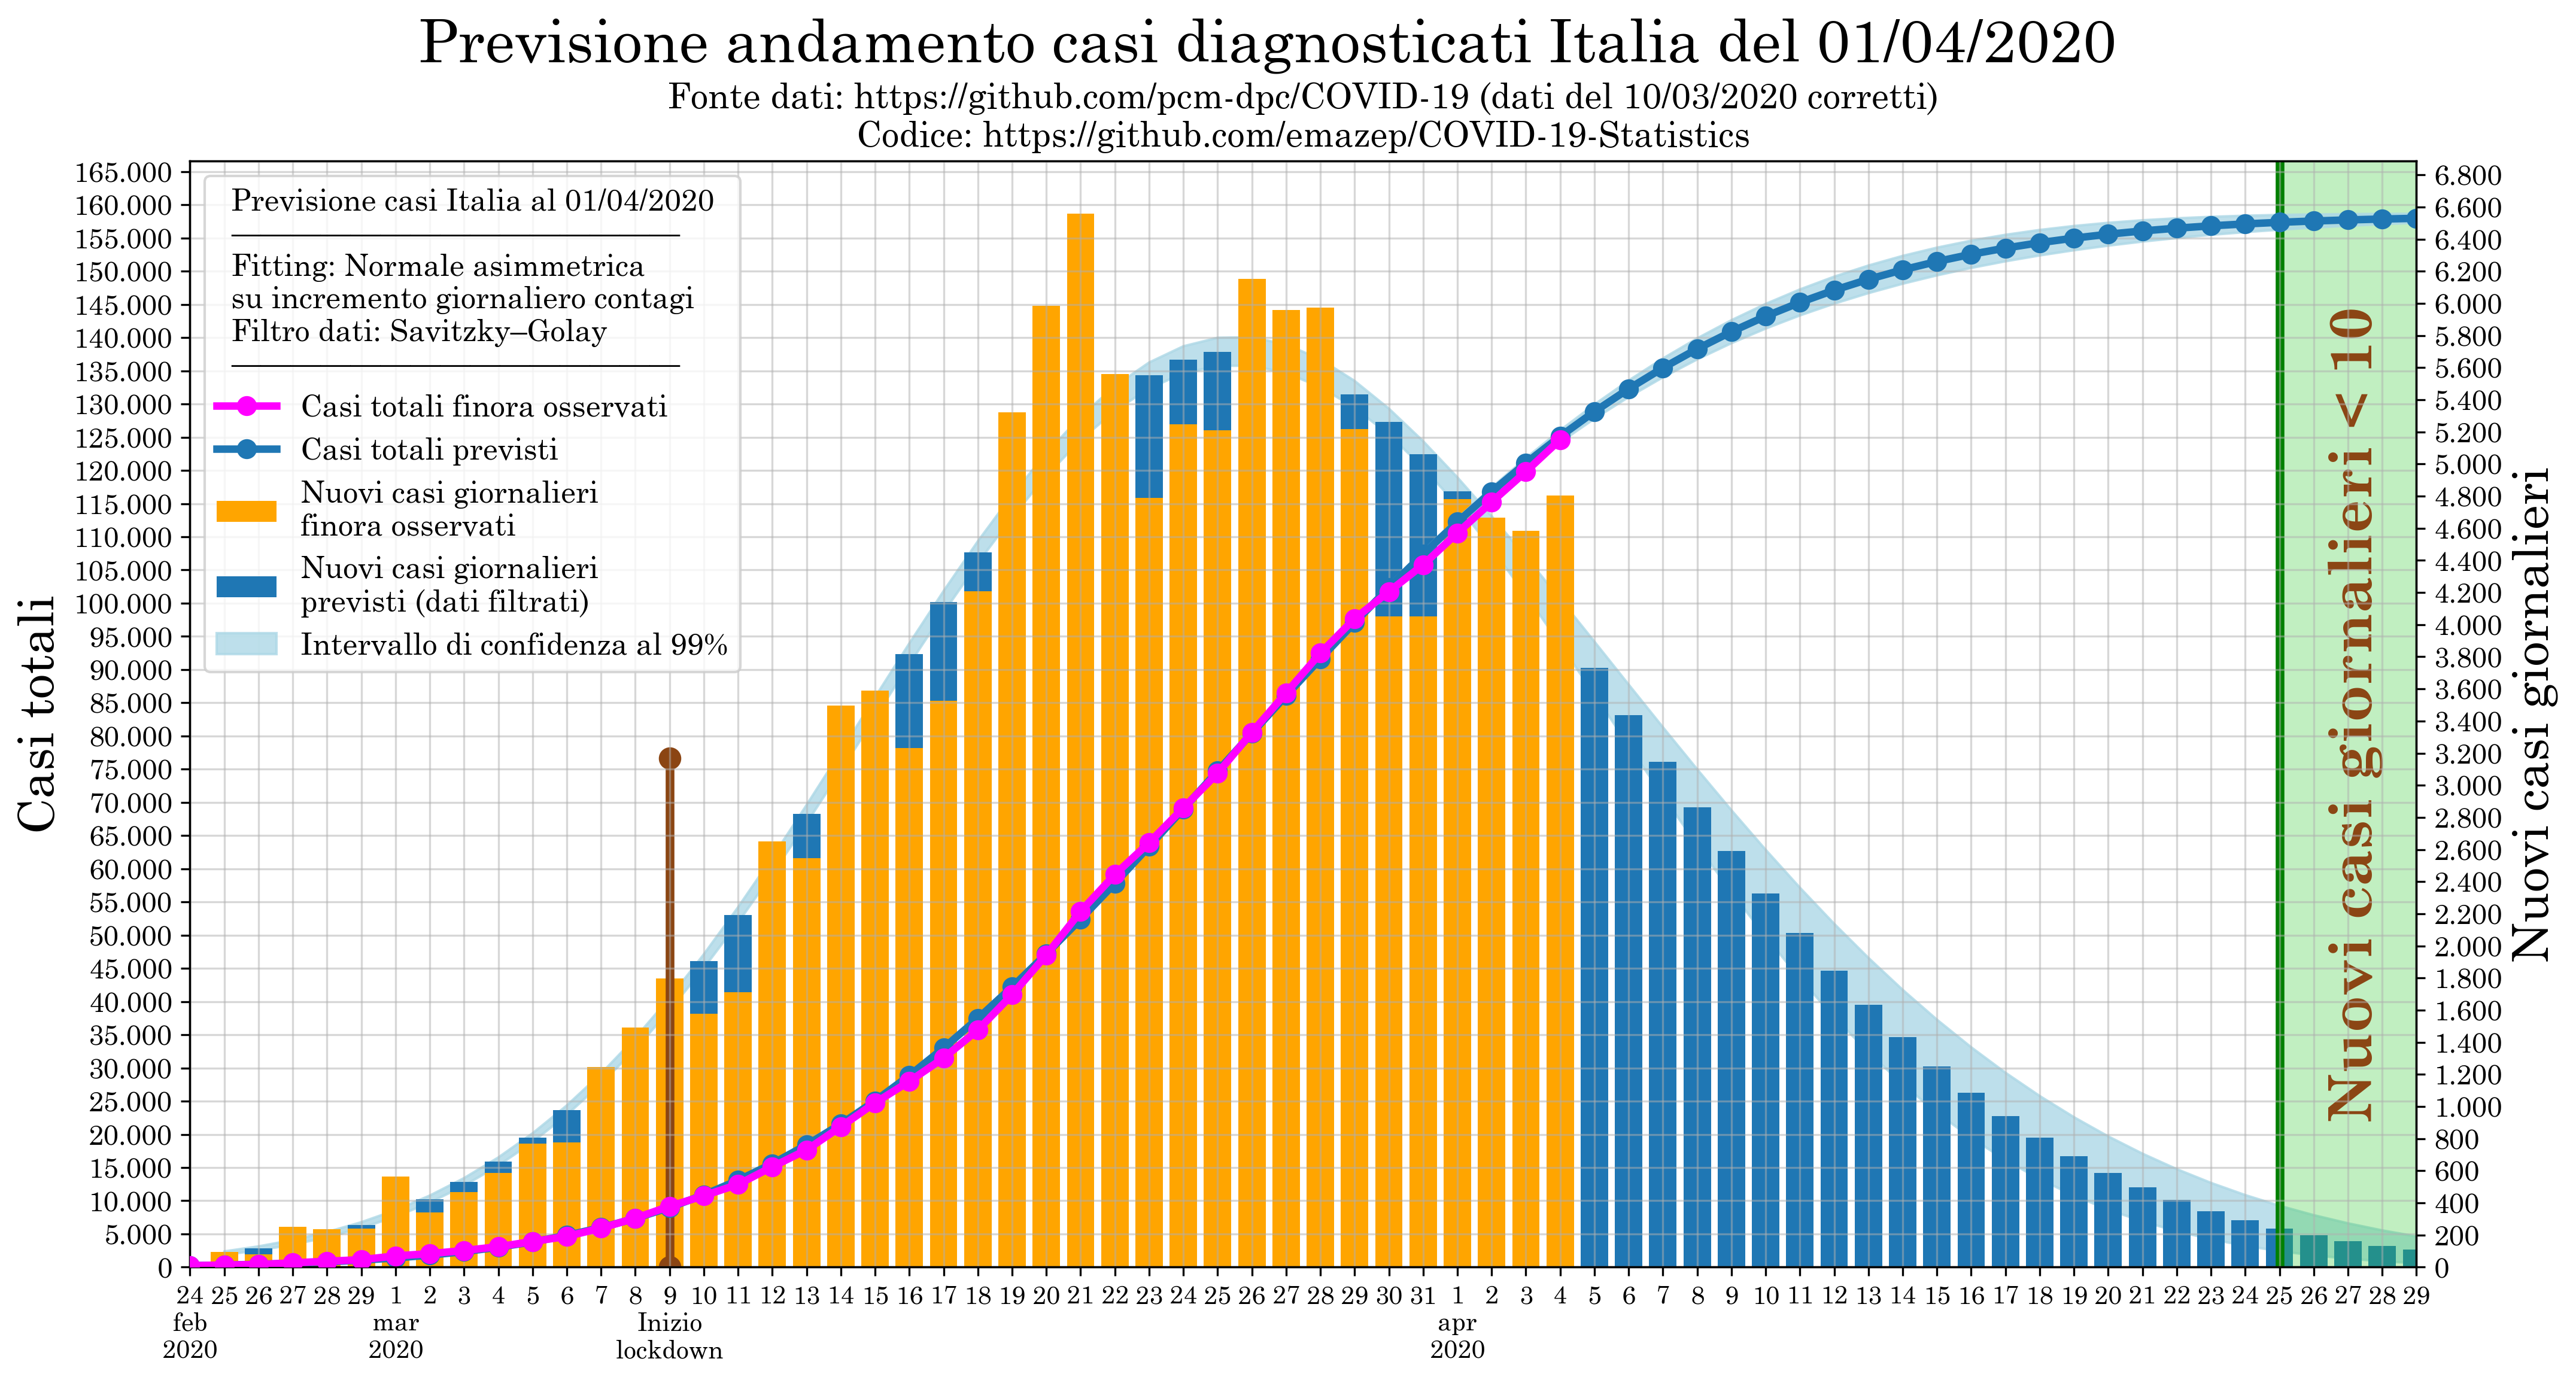

In [1050]:
plt.rcParams.update(mpl.rcParamsDefault)
set_plt_params()
rcParams['font.size'] = 12
#rcParams['axes.titlesize'] = 'x-large'

ax = df_it_fit.plot(
    y='totale_casi', label='Casi totali finora osservati',
    linewidth=3, markersize=7, marker='o', figsize=(16, 8), color='magenta', zorder=4
)
ax.plot(predicted_CUM_index, predicted_CUM, linewidth=3, markersize=7, marker='o', color='tab:blue', label='Casi totali previsti', zorder=2)
ax.fill_between(predicted_CUM_index, predicted_CUM-dely_CUM, predicted_CUM+dely_CUM, color='lightblue', alpha=0.8, zorder=1)

ax2 = ax.twinx()

ax2.bar(predicted_DELTA_index, predicted_DELTA, label='Nuovi casi giornalieri\nprevisti (dati filtrati)', color='tab:blue', zorder=0)
ax2.bar(df_it_fit.index, df_it_fit['totale_casi_DELTA'], label='Nuovi casi giornalieri\nfinora osservati', color='orange', zorder=1)
ax2.fill_between(
    predicted_DELTA_index, predicted_DELTA-dely_DELTA, predicted_DELTA+dely_DELTA, color='lightblue', alpha=0.8, zorder=0,
    label='Intervallo di confidenza al 99%'
)

ax.tick_params(axis='x', which='both', labelsize=10)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

special_x = {15: '\nInizio\nlockdown'}
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format_dates_from_numbers(x, p, special=special_x)))

ax.yaxis.set_major_locator(ticker.MultipleLocator(5_000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax.tick_params(axis='y', which='both', labelsize=11)
ax.set_ylabel('Casi totali', fontsize=20)

ax2.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', '.')))
ax2.tick_params(axis='y', which='both', labelsize=11)
ax2.set_ylabel('Nuovi casi giornalieri', fontsize=20)

ax.grid(which='both', alpha=ALPHA)
#ax.tick_params(axis='y', which='both', right=True, labelright=True)

#plt.axvline(x=48, linewidth=3.5, zorder=4, color='tab:red', label='Pasqua')
plt.axvline(x=14, linewidth=3.5, markersize=8, marker='o', zorder=4, color='saddlebrown', ymax=0.46)

plt.axvline(x=61, linewidth=3.5, zorder=0, color='green')
plt.axvspan(61, 66, facecolor='limegreen', alpha=0.3, zorder=0)
plt.text(
    0.985, 0.5, 'Nuovi casi giornalieri < 10',
    horizontalalignment='right', verticalalignment='center', rotation='vertical',
    transform=ax.transAxes, fontsize=24, fontweight='bold', color='saddlebrown'
)

ax.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
plt.xlim(right=65)
#ax.set_xlabel('Giorni di lockdown', fontsize=20)

ax.set_title(SUBTITLE_NO_CHN, fontsize=14)
plt.suptitle('Previsione andamento casi diagnosticati Italia del 01/04/2020', fontsize=24)

handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
sep = '\n———————————————'
ax.legend(
    handles+list(reversed(handles2)), labels+list(reversed(labels2)),
    title='Previsione casi Italia al 01/04/2020' + sep + '\nFitting: Normale asimmetrica\nsu incremento giornaliero contagi\nFiltro dati: Savitzky–Golay' + sep,
    fontsize=12, loc='upper left'
)
# bbox_to_anchor=(0.895, 0.6)

ax.set_zorder(1)
ax.patch.set_visible(False)

fig_forecast_fit_skewnormal = plt.gcf()

plt.show()

In [737]:
import os
from contextlib import contextmanager

@contextmanager
def save_in_dir(path):
    oldpath = os.getcwd()
    os.chdir(path)
    yield
    os.chdir(oldpath)

In [738]:
with save_in_dir(OUTPUT_PATH):
    fig_forecast_fit_skewnormal.savefig('FORE_01_forecast_fit_skewnormal.png', transparent=False)
    fig_fit_report.savefig('FORE_02_fit_report.png', transparent=False)

In [144]:
with save_in_dir(OUTPUT_PATH):
    fig_ita_chn_corrected_scaled.savefig('200_ita_chn_corr_scal.png', transparent=False)
    fig_ita_chn_corrected.savefig('201_ita_chn_corr.png', transparent=False)
    fig_ita_chn.savefig('202_ita_chn', transparent=False)